<a href="https://colab.research.google.com/github/igedeaguss/Magang-Pharos/blob/main/Recommendation%20System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pymssql

import pymssql
import pandas as pd
import numpy as np
import gspread
import seaborn as sns
import matplotlib.pyplot as plt
from gspread_dataframe import get_as_dataframe
import gspread
from google.colab import auth
from google.auth import default
import warnings

warnings.filterwarnings("ignore")
from google.colab import drive

#Mount Google Drive
drive.mount('/content/drive')

# Autentikasi Google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
url_dokter_survey = gc.open_by_url('https://docs.google.com/spreadsheets/d/1NIOYmajDgkSY7lfKNH_wHRz0I80eeZX2OWhNtAdMw-8/edit?gid=0#gid=0')
url_database_ethical = gc.open_by_url('https://docs.google.com/spreadsheets/d/1Qwurf3wlLDbrhWNB0XX1CgpK7GuHqCHZoAlQK_GJqek/edit?usp=sharing')
url_data_score_dokter = gc.open_by_url('https://docs.google.com/spreadsheets/d/1wIe9UOG8F6aNy1PF1UzGNQnkrcCm6DAD5zjUEnMbUo8/edit?usp=sharing')

In [ ]:
#Koneksi ke Database
connection = pymssql.connect(server='35.187.243.174', user='tim_powerbi',
                             password='dGltcG93ZXJiaQ', database='mkt_insight', port = '1433')


#Menarik data kode PI dan item kode
query_1 = """
SELECT DISTINCT KodePI, [Item Kode]
FROM mkt_insight.dbo.vw_DIR10001B
WHERE KodePI IS NOT NULL
  AND KodePI <> ''
  AND (Periode LIKE '%2023%' OR Periode LIKE '%2024%')
"""


#Menarik data yang menghasilkan item kode, nama produk, zat aktif, dan total penjualan
query_2 = """
SELECT z.[Nama Produk], s.[Item Kode], z.[Zat Aktif], SUM(s.[Value Sales]) AS [Total Penjualan]
FROM mkt_insight.dbo.DIR10001B s
INNER JOIN mkt_insight.dbo.ListAllProductComplete z ON s.[Item Kode]= z.[Kode Produk PI]
GROUP BY s.[Item Kode], z.[Nama Produk], z.[Zat Aktif]"""


#Menarik data nama outlet dan kode PI
query_3 = """
SELECT DISTINCT(KodePI), NamaOutlet, Propinsi, Alamat
FROM mkt_insight.dbo.Struktur_Marketing_PI
"""

# Menarik Data PSSP
query_4 = """
SELECT * FROM mkt_insight.dbo.PSSP_PIdanPML
"""

'''
data_1 = pd.DataFrame(pd.read_sql_query(query_1, connection))
data_2 = pd.DataFrame(pd.read_sql_query(query_2, connection))'''


# Dataset untuk mencocokan nama outlet terdaftar
data_struktur_PI = pd.DataFrame(pd.read_sql_query(query_3, connection))

#Dataset produk dan zat aktif perusahaan
data_produk_zat_aktif = pd.DataFrame(pd.read_sql_query(query_2, connection))

#Dataset PSSP
data_pssp = pd.DataFrame(pd.read_sql_query(query_4, connection))

#Dataset standarisasi
data_standarisasi = pd.DataFrame(pd.read_sql_query(query_1, connection))

# Menutup koneksi
connection.close()

In [ ]:
#data_ims = pd.read_csv('/content/drive/MyDrive/IMS_Subset.csv')

#Dataset survey berisi nama dokter, produk, dan jumlah peresepan dari bulan 1 - 12
data_survey = pd.read_excel('/content/drive/MyDrive/Dataset untuk sistem rekomendasi/06012025 Raw Data Hospital Survey Final.xlsx', sheet_name='Final')

#Dataset berisi nama dokter dan kode dokter yang terdata di Database
data_dokter = get_as_dataframe(url_dokter_survey.worksheet('DB Dokter'), evaluate_formulas=True)
data_dokter = data_dokter.loc[:, ~data_dokter.columns.str.contains('^Unnamed')]

"""
data_outlet = get_as_dataframe(url_dokter_survey.worksheet('DB Outlet'), evaluate_formulas=True)
data_outlet = data_outlet.loc[:, ~data_outlet.columns.str.contains('^Unnamed')]
"""
#Data semua produk dari survey berserta zat aktifnya
data_all_produk = get_as_dataframe(url_dokter_survey.worksheet('DB All Produk'), evaluate_formulas=True)
data_all_produk = data_all_produk.loc[:, ~data_all_produk.columns.str.contains('^Unnamed')]

#Dataset produk pharos beserta zat aktifnya
data_produk_pharos = get_as_dataframe(url_dokter_survey.worksheet('DB Produk PI'), evaluate_formulas=True)
data_produk_pharos = data_produk_pharos.loc[:, ~data_produk_pharos.columns.str.contains('^Unnamed')]

"""
#Dataset produk pharos yang berisi zat aktif, kode produk, dan rerata sales
data_produk_zat_aktif_1 = pd.DataFrame(pd.read_sql_query(query_3, connection))
"""

#Dataset produk ethical yang meliputi nama produk, spesialis, dan alasan penggunaan
data_produk_ethical = get_as_dataframe(url_database_ethical.worksheet('Kategori Produk'), evaluate_formulas=True, dtype={'Kd Item': str, ' ':str})
data_produk_ethical = data_produk_ethical.loc[:, ~data_produk_ethical.columns.str.contains('^Unnamed')]

'''
#Dataset standarisasi digunakan untuk mengetahui apakah produk pernah terjual di RS
data_standarisasi = pd.read_csv('/content/drive/MyDrive/Dataset untuk sistem rekomendasi/Data Standarisasi Produk.csv',header=None, names=['Item Kode', 'Kode PI'], dtype={'Item Kode': str})
'''

#Dataset score dokter. Menggunakan kolom Pelunasan AL
data_score_dokter =  get_as_dataframe(url_data_score_dokter.worksheet('Sheet1'), evaluate_formulas=True)
data_score_dokter = data_score_dokter.loc[:, ~data_score_dokter.columns.str.contains('^Unnamed')]

# Data Understanding

## Data Survey

In [ ]:
data_survey

,Tahun,Hospital Name,Doctor Name,Product Name without #,1,2,3,4,5,6,7,8,9,10,11,12
0,2020,RS Borromeus Bandung,Ahli Gizi Klinik,NUTREN DIABETES VANILA 400G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,2020,RS Borromeus Bandung,Ahli Gizi Klinik,PROTEN GOLD (VANILA),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0
2,2020,RS Borromeus Bandung,APOTEKER,ABILIFY 5 MG TAB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,30.0
3,2020,RS Borromeus Bandung,APOTEKER,AC SWAB 2% @100,15.0,80.0,0.0,0.0,35.0,0.0,0.0,0.0,50.0,20.0,0.0,486.0
4,2020,RS Borromeus Bandung,APOTEKER,ACANTHE SUNSCREEN SPF 30 CREAM 30GR,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659164,2024,RS Prima Medika,RSPM,ZOTER CREAM 5GR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
659165,2024,RS Prima Medika,RSPM,ZYCIN 500 MG TABLET,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,9.0,NaN,NaN,NaN
659166,2024,RS Prima Medika,RSPM,"ZYPRAZ 0,5 MG TAB",NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN
659167,2024,RS Prima Medika,Tias Puspaningrum Amd Kep,ACETIN 200 MG KAP,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_survey

## Data Dokter Database

In [ ]:
data_dokter

,Kd Outlet,Hospital Name,Doctor Name,Kd Dokter\n(DB Pharos),Doctor Name \n(DB Pharos),Kd Spesialis \n(DB Pharos),Nama Spesialis\n(DB Pharos)
0,F3001341,RS Borromeus Bandung,Ahli Gizi Klinik,-,NaN,-,-
1,F3001341,RS Borromeus Bandung,APOTEKER,-,NaN,-,-
2,F3001341,RS Borromeus Bandung,BIDAN,-,NaN,-,-
3,F3001341,RS Borromeus Bandung,dr. A. Fauzi Yahya_ Sp.JP(K),-,NaN,-,-
4,F3001341,RS Borromeus Bandung,dr. Adinugroho Saputra_ Sp.PK,-,NaN,-,-
...,...,...,...,...,...,...,...
5471,NaN,NaN,NaN,-,NaN,-,-
5472,NaN,NaN,NaN,-,NaN,-,-
5473,NaN,NaN,NaN,-,NaN,-,-
5474,NaN,NaN,NaN,-,NaN,-,-


## Data Produk dan Zat Aktifnya

In [ ]:
data_produk_zat_aktif

,Nama Produk,Item Kode,Zat Aktif,Total Penjualan
0,ALBOTHYL GEL 50 G,000102,POLICRESULEN,2.680906e+08
1,ALBOTHYL CONCENTRATE 10 ML,000113,POLICRESULEN,8.200165e+10
2,ALBOTHYL CONCENTRATE 100 ML,000124,POLICRESULEN,-4.300000e+05
3,ALBOTHYL OVULA,000135,POLICRESULEN,7.335827e+09
4,TRAMAL 50 INJEKSI,000344,TRAMADOL HCL,3.705644e+09
...,...,...,...,...
501,OZEN 10 MG FC TABLET 1*10,031980,,1.384577e+10
502,NOURISH SKIN ULTIMATE NEW FORMULA FC TAB 1*15`S,032068,,6.805046e+09
503,SALBUVEN AEROSOL 100 MCG,032145,SALBUTAMOL (ALBUTEROL),5.962428e+08
504,NUTRIMORE ENAPLEX D3 1000 IU CHEWABLE TABLET,032190,,1.126960e+09


## Data Produk Ethical

In [ ]:
data_produk_ethical

,,Nama Spesialis,Kd Item,Nama Produk,Keterangan Produk (Alasan Penggunaan Produk)
0,001,UMUM (GP),001653,ASCARDIA 80 TABLET FC,PRODUK UMUM (ANTIPLATELET)
1,001,UMUM (GP),002478,RECHOL 10 TABLET FC,PRODUK UMUM (ANTIHIPERLIPIDEMIA)
2,001,UMUM (GP),003590,RECHOL 20 FC TABLET,PRODUK UMUM (ANTIHIPERLIPIDEMIA)
3,001,UMUM (GP),009364,GIONIX 16 MG TABLET,PRODUK UMUM (ANTIHIPERTENSI)
4,001,UMUM (GP),009210,GIONIX 8 MG TABLET,PRODUK UMUM (ANTIHIPERTENSI)
...,...,...,...,...,...
1073,076,THT & BEDAH KEPALA LEHER,007054,SCELTO 30 INJEKSI,ANALGESIK NYERI AKUT
1074,076,THT & BEDAH KEPALA LEHER,013203,VIRIDIS 250 MG/5 ML SYRUP 60 ML,IMUNOMODULATOR
1075,076,THT & BEDAH KEPALA LEHER,013797,VIRIDIS 500 MG TABLET,IMUNOMODULATOR
1076,076,THT & BEDAH KEPALA LEHER,009573,XERXES IV 500/500 MG INFUSION,PRODUK ICU (ANTIBIOTIK)


## Data Score Dokter

In [ ]:
data_score_dokter

,customer_code,customer_name,specialist,Max Prd Akhir,Periode B0,Status PSSP,Pelunasan Trio,Pelunasan AL,Approve/Not,Parameter: BCG,Parameter: Periode,Parameter: Visit
0,A1000058,"ONGA, DR",UMUM (GP),202003.0,202411.0,Non Aktif,0.50057,-,Approved,-,0.620968,NaN
1,F1014631,"AMELIANAN SAFITRI PURBA SpPD, DR",PENYAKIT DALAM (INTERNIST),201506.0,202411.0,Non Aktif,0.699331,-,Approved,-,0.746269,NaN
2,F1041427,"PUTU WAHYU SUCITA DEWI SpA, DR",ANAK (PEDIATRIC),202402.0,202411.0,Non Aktif,0.433751,0.112647,Not Yet Approved,0.630769,1,NaN
3,A1003364,"FRANCISCUS GINTING SpPD, DR",PENYAKIT DALAM (INTERNIST),202402.0,202411.0,Non Aktif,0.53349,0.578139,Not Yet Approved,0.201498,0.342857,NaN
4,A1000191,"SYARIFUDDIN DALIMUNTHE SpA, DR",ANAK (PEDIATRIC),201106.0,202411.0,Non Aktif,0.245731,-,Approved,-,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
8486,M1000263,"IDA BAGUS NGURAH S SpTHT, DR",T H T (ENT),NaN,NaN,Non Aktif,-,-,Not Yet Approved,-,-,NaN
8487,Q1001355,"LILI HENDRIADY WIRA, DR",UMUM (GP),NaN,NaN,Non Aktif,-,-,Not Yet Approved,-,-,NaN
8488,Q1002068,"DAVID LOTISNA Sp.OG, DR",KANDUNGAN (OBSGYN),NaN,NaN,Non Aktif,-,-,Not Yet Approved,-,-,NaN
8489,Q1002430,JOSEPHINA OCTAVINAMADA,BAGIAN PEMBELIAN,NaN,NaN,Non Aktif,-,-,Not Yet Approved,-,-,NaN


## Data Standarisasi

In [ ]:
data_standarisasi

,KodePI,Item Kode
0,HO000306,004810
1,K1002904,000069
2,G4000406,010387
3,H2003536,025776
4,FN002526,009100
...,...,...
634503,F2002789,013038
634504,F4000676,007538
634505,Q1005491,007550
634506,B1003574,000080


## Data Struktur Marketing PI

In [ ]:
data_struktur_PI

,KodePI,NamaOutlet,Propinsi,Alamat
0,A1000004,"MARTHA FRISKA, RS/KARYA UTAMA SEHAT SEJAHTERA, PT",SUMATERA UTARA,JL. YOS SUDARSO KM 6 NO. 91
1,A1000006,"MESTIKA, APT",SUMATERA UTARA,"JL. YOS SUDARSO KM 16.8 NO. 13, SIMPANG KANTOR"
2,A1000008,"WINDA, APT",SUMATERA UTARA,JL. MARELAN NO. 17
3,A1000011,"CITRA, APT",SUMATERA UTARA,JL. DR. SUTOMO NO. 21
4,A1000012,"HUSADA, APT",SUMATERA UTARA,JL. IRIAN NO. 112
...,...,...,...,...
76971,T3000681,"RAMZI 2, APT",NUSA TENGGARA BARAT,DUSUN MPURI DESA BAKAJAYA KEC. WOJA KAB.-
76972,T3000682,"PERMATA HATI LOTIM, RSIA",NUSA TENGGARA BARAT,"JL. RAYA MASBAGIK SELONG, DSN. TANAK MAL, MASB..."
76973,T3000683,"FAMILY FARMA, APT",NUSA TENGGARA BARAT,JL. ADI SUCIPTO 30 A DAN B LINGKUNGAN MO-MATARAM
76974,T3000684,"LOKA MEDIKA FARMA, APT",NUSA TENGGARA BARAT,JL. AMIR HAMZAH MATARAM TIMUR KEC. MATARAM


## Data All Produk

In [ ]:
data_all_produk

,No,Nama Produk (Survey),Zat Aktif,Kd Item,Nama Produk PI \n(sebagai Kompetitor Langsung)
0,1,-- [dari Racikan],NaN,NaN,-
1,2,--- [dari Racikan],NaN,NaN,-
2,3,---- [dari Racikan],NaN,NaN,-
3,4,------- [dari Racikan],NaN,NaN,-
4,5,ATORVASTATIN 20MG TAB/AMAROX,ATORVASTATIN,12246.0,STAVINOR 20 MG FC TABLET
...,...,...,...,...,...
50340,50341,ZYVOX 600MG INJ 300ML,NaN,NaN,-
50341,50342,ZYVOX 600MG TAB,NaN,NaN,-
50342,50343,ZYVOX 600MG/300ML POLYBAG,NaN,NaN,-
50343,50344,Zyvox Infusion 2 mg/mL - 300 mL,NaN,NaN,-


## Data PSSP

In [ ]:
data_pssp

,Divisi KAM,CD Region,NM Region,NIP SM,NM SM,CD Area,NM Area,NIP ASM,NM ASM,CD Sub Area,...,CD Product,NM Product,CD Outlet,NM Outlet,QTY Estimasi,PRD Estimasi,Estimasi,PRD Pelunasan,Pelunasan,Score Loyal
0,KAM1,0259,PREMIER JATINEGARA + R PROGRES + CIREBON,L090436,WAHYU TRI WIBOWO,0262,MIKA + BMC + JWCC ASIH + CIREBON,L220055,MOH ROSIDI,1045,...,009672,FIXIPHAR 200 MG CAPSULE,FN003961,"MITRA KELUARGA BINTARO, RS",9.0,09-2024,2700000.0,08-2024,2295000.0,3.0
1,KAM1,0259,PREMIER JATINEGARA + R PROGRES + CIREBON,L090436,WAHYU TRI WIBOWO,0262,MIKA + BMC + JWCC ASIH + CIREBON,L220055,MOH ROSIDI,1045,...,009672,FIXIPHAR 200 MG CAPSULE,FN003961,"MITRA KELUARGA BINTARO, RS",9.4,10-2024,2820000.0,08-2024,2397000.0,3.0
2,KAM1,0259,PREMIER JATINEGARA + R PROGRES + CIREBON,L090436,WAHYU TRI WIBOWO,0262,MIKA + BMC + JWCC ASIH + CIREBON,L220055,MOH ROSIDI,1045,...,009672,FIXIPHAR 200 MG CAPSULE,FN003961,"MITRA KELUARGA BINTARO, RS",10.0,12-2024,3000000.0,10-2024,2549844.0,3.0
3,KAM1,0259,PREMIER JATINEGARA + R PROGRES + CIREBON,L090436,WAHYU TRI WIBOWO,0262,MIKA + BMC + JWCC ASIH + CIREBON,L220055,MOH ROSIDI,1045,...,024962,MAXICEF 1 G DRY INJECTION,FN003961,"MITRA KELUARGA BINTARO, RS",2.0,08-2024,620000.0,08-2024,527000.0,3.0
4,KAM1,0259,PREMIER JATINEGARA + R PROGRES + CIREBON,L090436,WAHYU TRI WIBOWO,0262,MIKA + BMC + JWCC ASIH + CIREBON,L220055,MOH ROSIDI,1045,...,024962,MAXICEF 1 G DRY INJECTION,FN003961,"MITRA KELUARGA BINTARO, RS",2.0,09-2024,620000.0,08-2024,527000.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92921,KAM2,0687,BEKASI 2,L080474,DAVID JEFFESON NAPITUPULU,0702,SILOAM + HOSANA 01,P210343,SUCI RADHIYAH,1027,...,007263,MOXAM 15,F1007393,"HOSANA I, APT",120.0,04-2024,28980000.0,04-2024,24633000.0,1.0
92922,KAM2,0687,BEKASI 2,L080474,DAVID JEFFESON NAPITUPULU,0702,SILOAM + HOSANA 01,P210343,SUCI RADHIYAH,1027,...,007263,MOXAM 15,F1007393,"HOSANA I, APT",120.0,11-2024,28980000.0,11-2024,24633000.0,1.0
92923,KAM2,0687,BEKASI 2,L080474,DAVID JEFFESON NAPITUPULU,0702,SILOAM + HOSANA 01,P210343,SUCI RADHIYAH,1027,...,007263,MOXAM 15,F1007393,"HOSANA I, APT",125.0,10-2024,30187500.0,10-2024,25659390.0,1.0
92924,KAM2,0687,BEKASI 2,L080474,DAVID JEFFESON NAPITUPULU,0702,SILOAM + HOSANA 01,P210343,SUCI RADHIYAH,1027,...,007263,MOXAM 15,F1007393,"HOSANA I, APT",130.0,05-2024,31395000.0,05-2024,26685750.0,1.0


# Data Cleaning

In [ ]:
#Mengisi kolom 1 - 12 yang null dengan 0
data_survey.iloc[:, 4:] = data_survey.iloc[:, 4:].fillna(0)

#Cleaning data zat aktif
data_produk_zat_aktif = data_produk_zat_aktif[data_produk_zat_aktif['Zat Aktif'] != '']
data_produk_zat_aktif['Zat Aktif'] = data_produk_zat_aktif['Zat Aktif'].str.replace('\n', '', regex=False).str.replace(', ', ',', regex=False)
data_all_produk['Zat Aktif'] = data_all_produk['Zat Aktif'].str.replace('+', ',', regex=False)

#Cleaning data pssp
data_pssp_1 = data_pssp[['CD Cust','NM Cust','CD Product','NM Product','Estimasi']]
data_pssp_1 = data_pssp_1.drop_duplicates()
data_pssp_1['CD Product'] = data_pssp_1['CD Product'].astype(str).str.zfill(6)

#drop row null
data_produk_zat_aktif = data_produk_zat_aktif.dropna(subset=['Zat Aktif'])
data_standarisasi = data_standarisasi.dropna()

#drop duplicate data
data_pssp = data_pssp.drop_duplicates()
data_standarisasi = data_standarisasi.drop_duplicates()
data_produk_ethical = data_produk_ethical.drop_duplicates()
data_produk_zat_aktif = data_produk_zat_aktif.drop_duplicates()

In [ ]:
'''
- Proses ini merupakan proses mengetahui apakah dokter di data survey ada di database.
- Dilakukan dengan cara join menggunakan nama dokter karena di data survey tidak ada kode dokter
- Selain itu mendapatkan kode dokter yang terdaftar di database
'''

#Memfilter data yang memiliki kode outlet dan kode dokter
data_dokter = data_dokter[(data_dokter['Kd Outlet'] != '-') & (data_dokter['Kd Dokter\n(DB Pharos)'] != '-')]

#Menggabungkan data survey dengan data dokter berdasarkan kolom 'Doctor Name'
data_merged = pd.merge(data_survey, data_dokter, on='Doctor Name', how='left')

#Drop data yang tidak ada kode outlet, kode dokter, nama spesialis
data_merged = data_merged.dropna(subset=['Kd Outlet','Kd Dokter\n(DB Pharos)', 'Nama Spesialis\n(DB Pharos)'])

#Membuat kolom Total
data_merged["Total"] = data_merged.iloc[:, 4:16].sum(axis=1)

data_merged = data_merged[data_merged['Total'] > 0]

# Menghapus baris yang mengandung kata 'retur' di nama produk
data_merged = data_merged[~data_merged['Product Name without #'].str.contains('retur', case=False, na=False)]

data_merged

,Tahun,Hospital Name_x,Doctor Name,Product Name without #,1,2,3,4,5,6,...,10,11,12,Kd Outlet,Hospital Name_y,Kd Dokter\n(DB Pharos),Doctor Name \n(DB Pharos),Kd Spesialis \n(DB Pharos),Nama Spesialis\n(DB Pharos),Total
1193,2020,RS Borromeus Bandung,dr. Adrian A. Nanere_ Sp.OG,AQUADEST PRO INJ 25ML (OTSU-WI),0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,F3001341,RS Borromeus Bandung,F1017371,"ADRIAN AGUSTINUS NANERE SpOG, DR",005,KANDUNGAN (OBSGYN),2.0
1194,2020,RS Borromeus Bandung,dr. Adrian A. Nanere_ Sp.OG,AQUADEST STERIL 500ML (IPHA),0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,F3001341,RS Borromeus Bandung,F1017371,"ADRIAN AGUSTINUS NANERE SpOG, DR",005,KANDUNGAN (OBSGYN),2.0
1195,2020,RS Borromeus Bandung,dr. Adrian A. Nanere_ Sp.OG,ASTHIN FORCE 6 MG TAB,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,17.0,F3001341,RS Borromeus Bandung,F1017371,"ADRIAN AGUSTINUS NANERE SpOG, DR",005,KANDUNGAN (OBSGYN),17.0
1196,2020,RS Borromeus Bandung,dr. Adrian A. Nanere_ Sp.OG,ATROPINE SULFATE INJ (ETHICA),0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,F3001341,RS Borromeus Bandung,F1017371,"ADRIAN AGUSTINUS NANERE SpOG, DR",005,KANDUNGAN (OBSGYN),4.0
1197,2020,RS Borromeus Bandung,dr. Adrian A. Nanere_ Sp.OG,B.CHROGUT 1 USP 40MM 1/2 CIRCLE TP 100CM SUTCO...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,F3001341,RS Borromeus Bandung,F1017371,"ADRIAN AGUSTINUS NANERE SpOG, DR",005,KANDUNGAN (OBSGYN),1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699876,2024,RS Prima Medika,"Prof. DR. dr. IB Tjakra Wibawa, Sp.B (K) Onk.F...",WING NEEDLE 25 ONEMED (B),0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,I1001005,RS Prima Medika,F1009536,"IB TJAKRA WIBAWA MANUABA SpBOnk, DR",025,BEDAH KANKER (ONKOLOGI),1.0
699877,2024,RS Prima Medika,"Prof. DR. dr. IB Tjakra Wibawa, Sp.B (K) Onk.F...",WINGED SURECAN B BRAUN,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,I1001005,RS Prima Medika,F1009536,"IB TJAKRA WIBAWA MANUABA SpBOnk, DR",025,BEDAH KANKER (ONKOLOGI),6.0
699878,2024,RS Prima Medika,"Prof. DR. dr. IB Tjakra Wibawa, Sp.B (K) Onk.F...",ZEGAVIT CAP,0.0,0.0,0.0,0.0,60.0,0.0,...,0.0,0.0,0.0,I1001005,RS Prima Medika,F1009536,"IB TJAKRA WIBAWA MANUABA SpBOnk, DR",025,BEDAH KANKER (ONKOLOGI),70.0
699879,2024,RS Prima Medika,"Prof. DR. dr. IB Tjakra Wibawa, Sp.B (K) Onk.F...","ZOLADEX 10,8 MG INJEKSI",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,I1001005,RS Prima Medika,F1009536,"IB TJAKRA WIBAWA MANUABA SpBOnk, DR",025,BEDAH KANKER (ONKOLOGI),1.0


In [ ]:
'''
- Mencari zat aktif apa yang ada di dokter dengan mengindentifikasi produk yang digunakan
- Pencarian zat aktif berdasarkan produk yang digunakan
'''

#Mengetahui zat aktif berdasarkan nama produk menggunakan nama produk dan metode inner
data_merged = data_merged.merge(data_all_produk[['Nama Produk (Survey)', 'Zat Aktif']],
                          left_on = 'Product Name without #',
                          right_on='Nama Produk (Survey)',
                          how='inner'
                          )
#Memfilter hanya muncul zat aktifnya
data_merged = data_merged[(data_merged['Zat Aktif'] != '-') & (data_merged['Zat Aktif'].isnull() == False)]

#Drop kolom yang tidak diperlukan
data_merged = data_merged.drop(columns=['Doctor Name','Product Name without #','Hospital Name_y','Nama Produk (Survey)'])

#Mengubah beberapa nama kolom
data_merged = data_merged.rename(columns = {
    'Kd Outlet' : "Kode RS",
    'Kd Dokter\n(DB Pharos)' : "Kode Dokter",
    'Doctor Name \n(DB Pharos)':"Nama Dokter",
    'Hospital Name_x':'Nama Rumah Sakit',
    'Kd Spesialis \n(DB Pharos)' : 'Kode Spesialis',
    'Nama Spesialis\n(DB Pharos)' : 'Nama Spesialis'
})
data_merged

,Tahun,Nama Rumah Sakit,1,2,3,4,5,6,7,8,...,10,11,12,Kode RS,Kode Dokter,Nama Dokter,Kode Spesialis,Nama Spesialis,Total,Zat Aktif
2,2020,RS Borromeus Bandung,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,17.0,F3001341,F1017371,"ADRIAN AGUSTINUS NANERE SpOG, DR",005,KANDUNGAN (OBSGYN),17.0,ASTAXANTHIN
3,2020,RS Borromeus Bandung,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,2.0,F3001341,F1017371,"ADRIAN AGUSTINUS NANERE SpOG, DR",005,KANDUNGAN (OBSGYN),4.0,ATROPINE
18,2020,RS Borromeus Bandung,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,...,0.0,0.0,10.0,F3001341,F1017371,"ADRIAN AGUSTINUS NANERE SpOG, DR",005,KANDUNGAN (OBSGYN),20.0,MULTIVITAMIN
19,2020,RS Borromeus Bandung,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,1.0,0.0,2.0,F3001341,F1017371,"ADRIAN AGUSTINUS NANERE SpOG, DR",005,KANDUNGAN (OBSGYN),5.0,POVIDONE IODINE
21,2020,RS Borromeus Bandung,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,35.0,F3001341,F1017371,"ADRIAN AGUSTINUS NANERE SpOG, DR",005,KANDUNGAN (OBSGYN),35.0,"CALCIUM, MAGNESIUM, ISOFLAVONE, VIT D3, VIT K,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294594,2024,RS Prima Medika,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,I1001005,F1009536,"IB TJAKRA WIBAWA MANUABA SpBOnk, DR",025,BEDAH KANKER (ONKOLOGI),3.0,#N/A (Did not find value '20021' in MATCH eval...
294595,2024,RS Prima Medika,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,I1001005,F1009536,"IB TJAKRA WIBAWA MANUABA SpBOnk, DR",025,BEDAH KANKER (ONKOLOGI),16.0,#N/A (Did not find value '20022' in MATCH eval...
294596,2024,RS Prima Medika,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,...,0.0,0.0,0.0,I1001005,F1009536,"IB TJAKRA WIBAWA MANUABA SpBOnk, DR",025,BEDAH KANKER (ONKOLOGI),45.0,#N/A (Did not find value '20088' in MATCH eval...
294735,2024,RS Prima Medika,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,I1001005,F1009536,"IB TJAKRA WIBAWA MANUABA SpBOnk, DR",025,BEDAH KANKER (ONKOLOGI),1.0,GOSERELIN ACETATE


In [ ]:
#Melakukan groupby berdasarkan kode rs, kode dokter, zat aktif
data_zat_aktif_dokter = data_merged.groupby(['Kode RS','Kode Dokter', 'Kode Spesialis','Zat Aktif'])['Total'].sum().reset_index()
data_zat_aktif_dokter

,Kode RS,Kode Dokter,Kode Spesialis,Zat Aktif,Total
0,A1005681,A1000684,003,#N/A (Did not find value '19546' in MATCH eval...,2.0
1,A1005681,A1000684,003,#N/A (Did not find value '20017' in MATCH eval...,2.0
2,A1005681,A1000684,003,#N/A (Did not find value '20058' in MATCH eval...,1.0
3,A1005681,A1000684,003,#N/A (Did not find value '20076' in MATCH eval...,1.0
4,A1005681,A1000684,003,#N/A (Did not find value '20107' in MATCH eval...,3.0
...,...,...,...,...,...
42233,I1001005,Q1002060,011,"MAGNESIUM HYDROXIDE, ALUMINUM HYDROXIDE",20.0
42234,I1001005,Q1002060,011,OFLOXACIN,6.0
42235,I1001005,Q1002060,011,PARACETAMOL,1.0
42236,I1001005,Q1002060,011,"PARACETAMOL, PSEUDOEPHEDRINE",50.0


# Dataset Rekomendasi

## Metode Sama Persis (Exact Match)

In [ ]:
'''
- Algoritma akan memeriksa apakah zat aktif di produk sama persis dengan zat aktif yang digunakan dokter. Jika
zat aktif produk cocok dengan zat aktif dokter, produk dianggap relevan untuk direkomendasikan
- Produk yang cocok dengan zat aktif dokter dipilih berdasarkan total penjualan tertinggi
- Hasil dataset rekomendasi berupa kode dokter, kode rs, kode spesialis,
zat aktif, nama produk, kode produk, potensi
'''

def zat_aktif_sama_persis(zat_aktif_produk, zat_aktif_dokter):
    # Ubah string zat aktif menjadi set
    set_produk = set(map(str.strip, zat_aktif_produk.split(',')))
    set_dokter = set(map(str.strip, zat_aktif_dokter.split(',')))

    # Cocokkan apakah set sama persis
    return set_produk == set_dokter


# Fungsi sistem rekomendasi
def sistem_rekomendasi(data_top_zat_aktif, data_produk):
    hasil_rekomendasi = []

    # Iterasi untuk setiap dokter
    for _, row_dokter in data_top_zat_aktif.iterrows():
        zat_aktif_dokter = row_dokter['Zat Aktif']
        kode_dokter = row_dokter['Kode Dokter']
        kode_outlet = row_dokter['Kode RS']
        kode_spesialis = row_dokter['Kode Spesialis']
        # Cari produk yang persis cocok dengan zat aktif dokter
        produk_cocok = data_produk[
            data_produk['Zat Aktif'].apply(lambda x: zat_aktif_sama_persis(x, zat_aktif_dokter))
        ]

        # Jika ada produk yang cocok
        if not produk_cocok.empty:
            # Ambil produk dengan rerata penjualan tertinggi
            produk_terbaik = produk_cocok.sort_values(by='Total Penjualan', ascending=False).iloc[0]
            hasil_rekomendasi.append({
                'Kode Dokter' : kode_dokter,
                'Kode RS' : kode_outlet,
                'Kode Spesialis' : kode_spesialis,
                'Zat Aktif': zat_aktif_dokter,
                'Nama Produk': produk_terbaik['Nama Produk'],
                'Kode Produk': produk_terbaik['Item Kode'],
                'Potensi' : row_dokter['Total']
            })

    # Mengembalikan hasil rekomendasi sebagai DataFrame
    return pd.DataFrame(hasil_rekomendasi)



# Menghasilkan rekomendasi
data_rekomendasi = sistem_rekomendasi(data_zat_aktif_dokter, data_produk_zat_aktif)

"""
data_rekomendasi = ( data_rekomendasi.groupby('Nama Dokter')
   .head(3)  # Ambil maksimal 3 baris per dokter
   .reset_index(drop=True)
   )
"""
data_rekomendasi

,Kode Dokter,Kode RS,Kode Spesialis,Zat Aktif,Nama Produk,Kode Produk,Potensi
0,A1000684,A1005681,003,CEFADROXIL,CEFADROXIL 500 MG CAPSULE OGB,018901,11.0
1,A1000684,A1005681,003,MUPIROCIN,MERTUS 10 G CREAM,010794,1.0
2,A1000827,A1005681,004,DOMPERIDONE,VOMARIN 10 MG FLASH TABLET,014204,1.0
3,A1000827,A1005681,004,GRANISETRON,GRAMET 3 MG/3 ML INJECTION,011223,5.0
4,A1000914,A1005681,008,AZITHROMYCIN,AZTRIN 200 MG/5 ML DRY SUSPENSION,009342,7.0
...,...,...,...,...,...,...,...
6708,Q1002060,I1001005,011,CEFADROXIL,CEFADROXIL 500 MG CAPSULE OGB,018901,195.0
6709,Q1002060,I1001005,011,CEFIXIME,FIXIPHAR 200 MG CAPSULE,009672,10.0
6710,Q1002060,I1001005,011,ESOMEPRAZOLE,ARCOLASE 40 MG DRY INJECTION,011531,5.0
6711,Q1002060,I1001005,011,FLUNARIZINE,DIZINE 10 MG TABLET,008704,5.0


In [ ]:
#Menggabungkan data rekomendasi dengan dataset skor dokter (pelunasan AL)
data_rekomendasi_score = pd.merge(
    data_rekomendasi,
    data_score_dokter[['customer_code','Pelunasan AL']],
    left_on = 'Kode Dokter',
    right_on = 'customer_code',
    how = "left"
)
data_rekomendasi_score.drop(columns=['customer_code'], inplace=True)

#Menggabungkan data rekomendasi dengan dataset produk ethical (mendapakan keterangan produk)
data_rekomendasi_ket = pd.merge(
    data_rekomendasi_score,
    data_produk_ethical[[" ", 'Kd Item' , 'Keterangan Produk (Alasan Penggunaan Produk)']],
    left_on = ['Kode Spesialis', 'Kode Produk'],
    right_on = [' ', 'Kd Item'],
    how = "left"
)
data_rekomendasi_ket = data_rekomendasi_ket.drop(columns=[" ","Kd Item"])

#Menggabungkan dataset rekomendasi dengan Standarisasi
data_final = data_rekomendasi_ket.copy()

# Buat set untuk kombinasi unik dari 'Item Kode' dan 'Kode PI' di data_standarisasi
standarisasi_set = set(zip(data_standarisasi['Item Kode'], data_standarisasi['KodePI']))
# Tentukan nilai 'Standarisasi' dengan vectorized operation
data_final['Sales 2 Tahun Terakhir'] = data_final.apply(
    lambda row: 'Ya' if (row['Kode Produk'], row['Kode RS']) in standarisasi_set else 'Tidak',
    axis=1)
data_final


data_final['Pelunasan AL'] = data_final['Pelunasan AL'].replace('-', 0.0).astype(float)
data_final['Keterangan Produk (Alasan Penggunaan Produk)'] = data_final['Keterangan Produk (Alasan Penggunaan Produk)'].fillna('BELUM TERCATAT')

data_final

,Kode Dokter,Kode RS,Kode Spesialis,Zat Aktif,Nama Produk,Kode Produk,Potensi,Pelunasan AL,Keterangan Produk (Alasan Penggunaan Produk),Sales 2 Tahun Terakhir
0,A1000684,A1005681,003,CEFADROXIL,CEFADROXIL 500 MG CAPSULE OGB,018901,11.0,0.00000,BELUM TERCATAT,Tidak
1,A1000684,A1005681,003,MUPIROCIN,MERTUS 10 G CREAM,010794,1.0,0.00000,BELUM TERCATAT,Tidak
2,A1000827,A1005681,004,DOMPERIDONE,VOMARIN 10 MG FLASH TABLET,014204,1.0,0.77995,ANTIEMETIK,Tidak
3,A1000827,A1005681,004,GRANISETRON,GRAMET 3 MG/3 ML INJECTION,011223,5.0,0.77995,DISPEPSIA,Ya
4,A1000914,A1005681,008,AZITHROMYCIN,AZTRIN 200 MG/5 ML DRY SUSPENSION,009342,7.0,0.00000,ANTIBIOTIK ISPA/PNEUMONIA,Tidak
...,...,...,...,...,...,...,...,...,...,...
6712,Q1002060,I1001005,011,CEFADROXIL,CEFADROXIL 500 MG CAPSULE OGB,018901,195.0,0.00000,BELUM TERCATAT,Ya
6713,Q1002060,I1001005,011,CEFIXIME,FIXIPHAR 200 MG CAPSULE,009672,10.0,0.00000,BELUM TERCATAT,Ya
6714,Q1002060,I1001005,011,ESOMEPRAZOLE,ARCOLASE 40 MG DRY INJECTION,011531,5.0,0.00000,PRODUK ICU (ANTIULCERANT),Ya
6715,Q1002060,I1001005,011,FLUNARIZINE,DIZINE 10 MG TABLET,008704,5.0,0.00000,BELUM TERCATAT,Tidak


In [ ]:
data_final['Pelunasan AL'] = data_final['Pelunasan AL'].fillna(0)
data_final = data_final.drop_duplicates()
data_final

,Kode Dokter,Kode RS,Kode Spesialis,Zat Aktif,Nama Produk,Kode Produk,Potensi,Pelunasan AL,Keterangan Produk (Alasan Penggunaan Produk),Sales 2 Tahun Terakhir
0,A1000684,A1005681,003,CEFADROXIL,CEFADROXIL 500 MG CAPSULE OGB,018901,11.0,0.00000,BELUM TERCATAT,Tidak
1,A1000684,A1005681,003,MUPIROCIN,MERTUS 10 G CREAM,010794,1.0,0.00000,BELUM TERCATAT,Tidak
2,A1000827,A1005681,004,DOMPERIDONE,VOMARIN 10 MG FLASH TABLET,014204,1.0,0.77995,ANTIEMETIK,Tidak
3,A1000827,A1005681,004,GRANISETRON,GRAMET 3 MG/3 ML INJECTION,011223,5.0,0.77995,DISPEPSIA,Ya
4,A1000914,A1005681,008,AZITHROMYCIN,AZTRIN 200 MG/5 ML DRY SUSPENSION,009342,7.0,0.00000,ANTIBIOTIK ISPA/PNEUMONIA,Tidak
...,...,...,...,...,...,...,...,...,...,...
6712,Q1002060,I1001005,011,CEFADROXIL,CEFADROXIL 500 MG CAPSULE OGB,018901,195.0,0.00000,BELUM TERCATAT,Ya
6713,Q1002060,I1001005,011,CEFIXIME,FIXIPHAR 200 MG CAPSULE,009672,10.0,0.00000,BELUM TERCATAT,Ya
6714,Q1002060,I1001005,011,ESOMEPRAZOLE,ARCOLASE 40 MG DRY INJECTION,011531,5.0,0.00000,PRODUK ICU (ANTIULCERANT),Ya
6715,Q1002060,I1001005,011,FLUNARIZINE,DIZINE 10 MG TABLET,008704,5.0,0.00000,BELUM TERCATAT,Tidak


## Cosine Similarity

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Menggunakan CountVectorizer untuk mengubah zat aktif menjadi vektor
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(', '))
X_produk = vectorizer.fit_transform(data_produk_zat_aktif['Zat Aktif'])
X_dokter = vectorizer.transform(data_zat_aktif_dokter['Zat Aktif'])

# Membuat DataFrame untuk menyimpan hasil rekomendasi
hasil_rekomendasi = []

# Menghitung cosine similarity
similarity_matrix = cosine_similarity(X_dokter, X_produk)

for i, kode_dokter in enumerate(data_zat_aktif_dokter['Kode Dokter']):
    for j, kode_produk in enumerate(data_produk_zat_aktif['Item Kode']):
        if similarity_matrix[i][j] > 0:  # Hanya ambil yang memiliki kesamaan
            hasil_rekomendasi.append({
                'Kode Dokter': kode_dokter,
                'Nama Dokter': data_zat_aktif_dokter.loc[i, 'Zat Aktif'],  # Menyimpan zat aktif dokter
                'Kode Produk': data_produk_zat_aktif.iloc[j, 1],
                'Nama Produk': data_produk_zat_aktif.iloc[j, 0],
                'Cosine Similarity': similarity_matrix[i][j],
                'Total Penjualan': data_produk_zat_aktif.iloc[j, 3]
            })

# Mengubah hasil rekomendasi menjadi DataFrame
data_rekomendasi_cosine = pd.DataFrame(hasil_rekomendasi)

In [ ]:
data_rekomendasi_cosine

,Kode Dokter,Nama Dokter,Kode Produk,Nama Produk,Cosine Similarity,Total Penjualan
0,A1000684,CEFADROXIL,018880,CETIRIZINE 10 MG FC TABLET OGB,1.0,7.307200e+08
1,A1000684,CEFADROXIL,018901,CEFADROXIL 500 MG CAPSULE OGB,1.0,1.280111e+09
2,A1000914,LEVOFLOXACIN,006383,NISLEV 500 TABLET FC,1.0,4.339401e+09
3,A1000914,LEVOFLOXACIN,007494,NISLEV IV 500 MG INFUSION,1.0,1.750760e+09
4,A1000914,LEVOFLOXACIN,011300,NISLEV 750 MG FC CAPLET,1.0,4.870150e+08
...,...,...,...,...,...,...
10041,I1001247,CEFADROXIL,018901,CEFADROXIL 500 MG CAPSULE OGB,1.0,1.280111e+09
10042,I1001379,CITICOLINE,009540,ZEUFOR 500 MG TABLET,1.0,4.363295e+09
10043,I1001379,CITICOLINE,012961,ZEUFOR 1000 MG/8ML INJECTION,1.0,1.917895e+09
10044,Q1002060,CEFADROXIL,018880,CETIRIZINE 10 MG FC TABLET OGB,1.0,7.307200e+08


In [ ]:
data_rekomendasi_cosine[data_rekomendasi_cosine['Cosine Similarity'] < 1.0]

,Kode Dokter,Nama Dokter,Kode Produk,Nama Produk,Cosine Similarity,Total Penjualan
11,A1000946,"CANDESARTAN, AMLODIPINE",009210,GIONIX 8 MG TABLET,0.707107,5.155350e+09
12,A1000946,"CANDESARTAN, AMLODIPINE",009364,GIONIX 16 MG TABLET,0.707107,4.325040e+09
13,A1000946,"CANDESARTAN, AMLODIPINE",017801,AMLODIPINE 5 MG TABLET OGB,0.707107,7.508450e+09
14,A1000946,"CANDESARTAN, AMLODIPINE",017812,AMLODIPINE 10 MG TABLET OGB,0.707107,7.764936e+09
15,A1000946,"CANDESARTAN, AMLODIPINE",026238,GENSIA TAB 5 MG,0.707107,5.647179e+08
...,...,...,...,...,...,...
9819,M1000136,"PARACETAMOL, IBUPROFEN",006064,PRORIS SUPPOSITORIA,0.707107,9.477674e+10
9820,M1000136,"PARACETAMOL, IBUPROFEN",007550,PRAXION 100MG/ML DROPS SUSPENSI,0.707107,5.863809e+10
9821,M1000136,"PARACETAMOL, IBUPROFEN",016426,PANOREX 10 MG/ML INFUSION 100 ML,0.707107,8.179980e+09
9822,M1000136,"PARACETAMOL, IBUPROFEN",016272,RODEMOL EXTRA 500/50 MG CAPLETS,0.707107,5.074560e+08


In [ ]:
data_rekomendasi_cosine['Cosine Similarity'].unique()

array([1.        , 0.70710678])

# PSSP

In [ ]:
data_pssp_1 = data_pssp[['CD Cust','NM Cust','CD Product',"NM Product",'CD Outlet', 'NM Outlet', 'Score Loyal']]
data_pssp_1

,CD Cust,NM Cust,CD Product,NM Product,CD Outlet,NM Outlet,Score Loyal
0,F1024744,"EDWIN RUSLI WIDJAJA SpAN, DR",000344,TRAMAL 50 INJEKSI,FN003961,"MITRA KELUARGA BINTARO, RS",9.0
1,F1024744,"EDWIN RUSLI WIDJAJA SpAN, DR",000344,TRAMAL 50 INJEKSI,FN003961,"MITRA KELUARGA BINTARO, RS",9.0
2,F1024744,"EDWIN RUSLI WIDJAJA SpAN, DR",000344,TRAMAL 50 INJEKSI,FN003961,"MITRA KELUARGA BINTARO, RS",9.0
3,F1024744,"EDWIN RUSLI WIDJAJA SpAN, DR",000355,TRAMAL 100 INJEKSI,FN003961,"MITRA KELUARGA BINTARO, RS",9.0
4,F1024744,"EDWIN RUSLI WIDJAJA SpAN, DR",000355,TRAMAL 100 INJEKSI,FN003961,"MITRA KELUARGA BINTARO, RS",9.0
...,...,...,...,...,...,...,...
97490,F1044358,"TIRTA APRIANDI, DR",010959,BLISTRA 10 MG/10 ML INJECTION,F1013396,"MAYAPADA, RS / NIRMALA KENCANA MAS, PT",1.0
97491,F1044358,"TIRTA APRIANDI, DR",010959,BLISTRA 10 MG/10 ML INJECTION,F1013396,"MAYAPADA, RS / NIRMALA KENCANA MAS, PT",1.0
97492,F1044358,"TIRTA APRIANDI, DR",010959,BLISTRA 10 MG/10 ML INJECTION,F1013396,"MAYAPADA, RS / NIRMALA KENCANA MAS, PT",1.0
97493,F1044358,"TIRTA APRIANDI, DR",010959,BLISTRA 10 MG/10 ML INJECTION,F1013396,"MAYAPADA, RS / NIRMALA KENCANA MAS, PT",1.0


In [ ]:
# Buat set untuk kombinasi unik dari kode dokter, kode produk, kode rs
pssp_set = set(zip(data_pssp_1['CD Cust'], data_pssp_1['CD Product'], data_pssp_1['CD Outlet']))
# Tentukan nilai dengan vectorized operation
data_final['Pernah Terjual'] = data_final.apply(
    lambda row: 'Ya' if (row['Kode Dokter'], row['Kode Produk'], row['Kode RS']) in pssp_set else 'Tidak',
    axis=1)
data_final

,Kode Dokter,Kode RS,Kode Spesialis,Zat Aktif,Nama Produk,Kode Produk,Potensi,Pelunasan AL,Keterangan Produk (Alasan Penggunaan Produk),Sales 2 Tahun Terakhir,Pernah,Pernah Terjual
0,A1000684,A1005681,003,CEFADROXIL,CEFADROXIL 500 MG CAPSULE OGB,018901,11.0,0.00000,BELUM TERCATAT,Tidak,Tidak,Tidak
1,A1000684,A1005681,003,MUPIROCIN,MERTUS 10 G CREAM,010794,1.0,0.00000,BELUM TERCATAT,Tidak,Tidak,Tidak
2,A1000827,A1005681,004,DOMPERIDONE,VOMARIN 10 MG FLASH TABLET,014204,1.0,0.77995,ANTIEMETIK,Tidak,Tidak,Tidak
3,A1000827,A1005681,004,GRANISETRON,GRAMET 3 MG/3 ML INJECTION,011223,5.0,0.77995,DISPEPSIA,Ya,Tidak,Tidak
4,A1000914,A1005681,008,AZITHROMYCIN,AZTRIN 200 MG/5 ML DRY SUSPENSION,009342,7.0,0.00000,ANTIBIOTIK ISPA/PNEUMONIA,Tidak,Tidak,Tidak
...,...,...,...,...,...,...,...,...,...,...,...,...
6712,Q1002060,I1001005,011,CEFADROXIL,CEFADROXIL 500 MG CAPSULE OGB,018901,195.0,0.00000,BELUM TERCATAT,Ya,Tidak,Tidak
6713,Q1002060,I1001005,011,CEFIXIME,FIXIPHAR 200 MG CAPSULE,009672,10.0,0.00000,BELUM TERCATAT,Ya,Tidak,Tidak
6714,Q1002060,I1001005,011,ESOMEPRAZOLE,ARCOLASE 40 MG DRY INJECTION,011531,5.0,0.00000,PRODUK ICU (ANTIULCERANT),Ya,Tidak,Tidak
6715,Q1002060,I1001005,011,FLUNARIZINE,DIZINE 10 MG TABLET,008704,5.0,0.00000,BELUM TERCATAT,Tidak,Tidak,Tidak


# History Produk

In [ ]:
"""
Pembuatan kolom history produk
- Melihat produk yang mirip berdasarkan zat aktif
- Metode dilakukan dengan membuat dataset berisi kode dokter, zat aktif, dan nama produk.
  Pencocokan dilakukan berdasarkan kode dokter dan zat aktfinya lalu munculkan produknya
- Nama produk diambil dari data survey
"""

#Memfilter data yang memiliki kode outlet dan kode dokter
data_dokter = data_dokter[(data_dokter['Kd Outlet'] != '-') & (data_dokter['Kd Dokter\n(DB Pharos)'] != '-')]

#Menggabungkan data survey dengan data dokter berdasarkan kolom 'Doctor Name'
data_merged_1 = pd.merge(data_survey, data_dokter, on='Doctor Name', how='left')

#Drop data yang tidak ada kode outlet, kode dokter, nama spesialis
data_merged_1 = data_merged_1.dropna(subset=['Kd Outlet','Kd Dokter\n(DB Pharos)', 'Nama Spesialis\n(DB Pharos)'])


#Membuat kolom Total
data_merged_1["Total"] = data_merged_1.iloc[:, 4:16].sum(axis=1)

data_merged_1 = data_merged_1[data_merged_1['Total'] > 0]

# Menghapus baris yang mengandung kata 'retur' di nama produk
data_merged_1 = data_merged_1[~data_merged_1['Product Name without #'].str.contains('retur', case=False, na=False)]

#Mengetahui zat aktif berdasarkan nama produk menggunakan nama produk dan metode inner
data_merged_1 = data_merged_1.merge(data_all_produk[['Nama Produk (Survey)', 'Zat Aktif']],
                          left_on = 'Product Name without #',
                          right_on='Nama Produk (Survey)',
                          how='inner'
                          )
#Memfilter hanya muncul zat aktifnya
data_merged_1 = data_merged_1[(data_merged_1['Zat Aktif'] != '-') & (data_merged_1['Zat Aktif'].isnull() == False)]

data_merged_1 = data_merged_1[['Product Name without #','Kd Dokter\n(DB Pharos)','Doctor Name \n(DB Pharos)','Zat Aktif']]

data_merged_1 = data_merged_1.drop_duplicates()


# Grupkan produk berdasarkan Kode Dokter dan Zat Aktif, lalu gabungkan nama produk dengan pemisah ";"
history_produk = data_merged_1.groupby(['Kd Dokter\n(DB Pharos)', 'Zat Aktif'])['Product Name without #'].apply(
    lambda x: '; '.join(x.dropna().unique())
).reset_index()

history_produk = history_produk.rename(columns={'Kd Dokter\n(DB Pharos)' : 'Kode Dokter','Product Name without #' : "Produk Serupa"})
history_produk

,Kode Dokter,Zat Aktif,Produk Serupa
0,A1000505,CLOFIBRATE,Clofritis 10mg Tab
1,A1000612,#N/A (Did not find value '19595' in MATCH eval...,IMUFOR PLUS SIRUP
2,A1000612,#N/A (Did not find value '19639' in MATCH eval...,IMUNPED 60 ML SIRUP
3,A1000612,ALLOPURINOL,ZYLORIC 100 MG TAB
4,A1000612,"AMOXICILLIN, CLAVULANIC ACID",CLAMIXIN 250 MG/5 ML FORTE DRY SIRUP
...,...,...,...
40351,Q1002442,IPRATROPIUM BROMIDE,BRICASMA INJEKSI
40352,Q1002442,"KARBOHIDRAT, ELEKTROLIT",ASERING 500 ML
40353,Q1002442,MULTIVITAMIN,CERNEVIT INJEKSI
40354,Q1002442,PROGESTERONE,CYGEST 400 MG OVULA


In [ ]:
data_final_1 = data_final.copy()
data_final_1 = data_final_1.merge(
    history_produk,
    on=['Kode Dokter', 'Zat Aktif'],
    how='left'
).rename(columns={'Produk Serupa': 'History Produk'})

data_final_1

,Kode Dokter,Kode RS,Kode Spesialis,Zat Aktif,Nama Produk,Kode Produk,Potensi,Pelunasan AL,Keterangan Produk (Alasan Penggunaan Produk),Sales 2 Tahun Terakhir,Pernah,Pernah Terjual,History Produk
0,A1000684,A1005681,003,CEFADROXIL,CEFADROXIL 500 MG CAPSULE OGB,018901,11.0,0.00000,BELUM TERCATAT,Tidak,Tidak,Tidak,IH CEFADROXIL 500 MG CAPSULE (CEFADROXIL); CEF...
1,A1000684,A1005681,003,MUPIROCIN,MERTUS 10 G CREAM,010794,1.0,0.00000,BELUM TERCATAT,Tidak,Tidak,Tidak,IH PIBAKSIN OINT 10 G (MUPIROCIN)
2,A1000827,A1005681,004,DOMPERIDONE,VOMARIN 10 MG FLASH TABLET,014204,1.0,0.77995,ANTIEMETIK,Tidak,Tidak,Tidak,GALFLUX 10 MG TABLET (DOMPERIDONE)
3,A1000827,A1005681,004,GRANISETRON,GRAMET 3 MG/3 ML INJECTION,011223,5.0,0.77995,DISPEPSIA,Ya,Tidak,Tidak,GRANON 3 MG/3 ML INJECTION (GRANISETRON)
4,A1000914,A1005681,008,AZITHROMYCIN,AZTRIN 200 MG/5 ML DRY SUSPENSION,009342,7.0,0.00000,ANTIBIOTIK ISPA/PNEUMONIA,Tidak,Tidak,Tidak,IH AZITHROMYCIN 500 MG TABLET (AZITHROMYCIN)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6712,Q1002060,I1001005,011,CEFADROXIL,CEFADROXIL 500 MG CAPSULE OGB,018901,195.0,0.00000,BELUM TERCATAT,Ya,Tidak,Tidak,CEFADROXIL 500MG TAB
6713,Q1002060,I1001005,011,CEFIXIME,FIXIPHAR 200 MG CAPSULE,009672,10.0,0.00000,BELUM TERCATAT,Ya,Tidak,Tidak,CEPTIK 100 MG TAB
6714,Q1002060,I1001005,011,ESOMEPRAZOLE,ARCOLASE 40 MG DRY INJECTION,011531,5.0,0.00000,PRODUK ICU (ANTIULCERANT),Ya,Tidak,Tidak,ERYSANBE 500 MG TAB
6715,Q1002060,I1001005,011,FLUNARIZINE,DIZINE 10 MG TABLET,008704,5.0,0.00000,BELUM TERCATAT,Tidak,Tidak,Tidak,FLUNARIZIN 5MG TAB


In [ ]:
data_merged_1[data_merged_1['Kd Dokter\n(DB Pharos)'] == 'A1000684']

,Product Name without #,Kd Dokter\n(DB Pharos),Doctor Name \n(DB Pharos),Zat Aktif
252194,IH CEFADROXIL 500 MG CAPSULE (CEFADROXIL),A1000684,"ERINA OUTRY SIREGAR SpB, DR",CEFADROXIL
252195,IH KETOROLAC 10 MG TABLET (KETOROLAC),A1000684,"ERINA OUTRY SIREGAR SpB, DR",#N/A (Did not find value '19197' in MATCH eval...
252196,IH PIBAKSIN OINT 10 G (MUPIROCIN),A1000684,"ERINA OUTRY SIREGAR SpB, DR",#N/A (Did not find value '19282' in MATCH eval...
252198,IMODIUM 2 MG TABLET (LOPERAMIDE),A1000684,"ERINA OUTRY SIREGAR SpB, DR",#N/A (Did not find value '19546' in MATCH eval...
252200,"HAEMOCAINE OINT 15 G (LIDOCAINE, HYDROCORTISON...",A1000684,"ERINA OUTRY SIREGAR SpB, DR","LIDOCAINE, HYDROCORTISONE ACETATE, ALUMINUM SU..."
252207,INFUSAN RL INFUS 500 ML SINGLE PORT (RINGER LA...,A1000684,"ERINA OUTRY SIREGAR SpB, DR",#N/A (Did not find value '20107' in MATCH eval...
252209,INFUSAN NS INFUS 500 ML SINGLE PORT (NORMAL SA...,A1000684,"ERINA OUTRY SIREGAR SpB, DR",#N/A (Did not find value '20058' in MATCH eval...
252210,"BACTESYN 375 MG TABLET (AMPICILLIN, SULBACTAM)",A1000684,"ERINA OUTRY SIREGAR SpB, DR","AMPICILLIN, SULBACTAM"
252211,ASERING INFUS 500 ML (RINGER ACETATE),A1000684,"ERINA OUTRY SIREGAR SpB, DR","KARBOHIDRAT, ELEKTROLIT"
252212,INFUSAN NACL 0.9% 100 ML (NORMAL SALINE),A1000684,"ERINA OUTRY SIREGAR SpB, DR",#N/A (Did not find value '20017' in MATCH eval...


In [ ]:
data_final_new = data_final_1.merge(data_dokter[['Kd Dokter\n(DB Pharos)','Doctor Name \n(DB Pharos)','Kd Spesialis \n(DB Pharos)','Nama Spesialis\n(DB Pharos)']],
                              left_on = ['Kode Dokter','Kode Spesialis'],
                              right_on = ['Kd Dokter\n(DB Pharos)','Kd Spesialis \n(DB Pharos)'],
                              how = 'left')
data_final_new = data_final_new.drop(columns=['Kd Dokter\n(DB Pharos)','Kd Spesialis \n(DB Pharos)'])

data_final_new = data_final_new.merge(data_struktur_PI[['KodePI','NamaOutlet']],
                              left_on = 'Kode RS',
                              right_on = ['KodePI'],
                              how = 'left')
data_final_new = data_final_new.drop(columns="KodePI")

data_final_new = data_final_new.rename(columns={
    'Doctor Name \n(DB Pharos)':'Nama Dokter',
    'Nama Spesialis\n(DB Pharos)' : 'Spesialis',
    'NamaOutlet' : 'Nama RS'
})

data_final_new = data_final_new.reindex(columns=['Kode Dokter','Nama Dokter','Kode RS','Nama RS','Kode Spesialis','Spesialis',
                                             'Zat Aktif','Kode Produk','Nama Produk','Keterangan Produk (Alasan Penggunaan Produk)',
                                             'Potensi', 'Pelunasan AL','Sales 2 Tahun Terakhir', 'Pernah Terjual','History Produk'])

data_final_new = data_final_new.drop_duplicates()
data_final_new

,Kode Dokter,Nama Dokter,Kode RS,Nama RS,Kode Spesialis,Spesialis,Zat Aktif,Kode Produk,Nama Produk,Keterangan Produk (Alasan Penggunaan Produk),Potensi,Pelunasan AL,Sales 2 Tahun Terakhir,Pernah Terjual,History Produk
0,A1000684,"ERINA OUTRY SIREGAR SpB, DR",A1005681,"COLUMBIA ASIA MEDAN, RS",003,BEDAH (SURGEON),CEFADROXIL,018901,CEFADROXIL 500 MG CAPSULE OGB,BELUM TERCATAT,11.0,0.00000,Tidak,Tidak,IH CEFADROXIL 500 MG CAPSULE (CEFADROXIL); CEF...
1,A1000684,"ERINA OUTRY SIREGAR SpB, DR",A1005681,"COLUMBIA ASIA MEDAN, RS",003,BEDAH (SURGEON),MUPIROCIN,010794,MERTUS 10 G CREAM,BELUM TERCATAT,1.0,0.00000,Tidak,Tidak,IH PIBAKSIN OINT 10 G (MUPIROCIN)
2,A1000827,"ABIRAN NABABAN SpPD, DR",A1005681,"COLUMBIA ASIA MEDAN, RS",004,PENYAKIT DALAM (INTERNIST),DOMPERIDONE,014204,VOMARIN 10 MG FLASH TABLET,ANTIEMETIK,1.0,0.77995,Tidak,Tidak,GALFLUX 10 MG TABLET (DOMPERIDONE)
3,A1000827,"ABIRAN NABABAN SpPD, DR",A1005681,"COLUMBIA ASIA MEDAN, RS",004,PENYAKIT DALAM (INTERNIST),GRANISETRON,011223,GRAMET 3 MG/3 ML INJECTION,DISPEPSIA,5.0,0.77995,Ya,Tidak,GRANON 3 MG/3 ML INJECTION (GRANISETRON)
4,A1000914,"TAMSIL SYAFIUDIN SpP, DR",A1005681,"COLUMBIA ASIA MEDAN, RS",008,PARU (PULMONOLOGI),AZITHROMYCIN,009342,AZTRIN 200 MG/5 ML DRY SUSPENSION,ANTIBIOTIK ISPA/PNEUMONIA,7.0,0.00000,Tidak,Tidak,IH AZITHROMYCIN 500 MG TABLET (AZITHROMYCIN)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,Q1002060,"I WAYAN WIDANA SpAN, DR",I1001005,"PRIMA MEDIKA, RSU",011,ANESTESI,CEFADROXIL,018901,CEFADROXIL 500 MG CAPSULE OGB,BELUM TERCATAT,195.0,0.00000,Ya,Tidak,CEFADROXIL 500MG TAB
9574,Q1002060,"I WAYAN WIDANA SpAN, DR",I1001005,"PRIMA MEDIKA, RSU",011,ANESTESI,CEFIXIME,009672,FIXIPHAR 200 MG CAPSULE,BELUM TERCATAT,10.0,0.00000,Ya,Tidak,CEPTIK 100 MG TAB
9575,Q1002060,"I WAYAN WIDANA SpAN, DR",I1001005,"PRIMA MEDIKA, RSU",011,ANESTESI,ESOMEPRAZOLE,011531,ARCOLASE 40 MG DRY INJECTION,PRODUK ICU (ANTIULCERANT),5.0,0.00000,Ya,Tidak,ERYSANBE 500 MG TAB
9576,Q1002060,"I WAYAN WIDANA SpAN, DR",I1001005,"PRIMA MEDIKA, RSU",011,ANESTESI,FLUNARIZINE,008704,DIZINE 10 MG TABLET,BELUM TERCATAT,5.0,0.00000,Tidak,Tidak,FLUNARIZIN 5MG TAB


In [ ]:
import re

data_final_2 = data_final_new.copy()

def extract_product_name(product):
    # Gunakan regex untuk mengambil teks sebelum angka atau tanda kurung
    match = re.match(r"^(.*?)(\d|[\(])", product)
    return match.group(1).strip() if match else product.strip()

# Terapkan untuk kolom produk rekomendasi
data_final_2['Nama Produk'] = data_final_2['Nama Produk'].apply(extract_product_name)

# Terapkan untuk kolom produk history
def process_history_products(history):
    if pd.isna(history):  # Jika kolom kosong, kembalikan NaN
        return history
    # Pisahkan produk berdasarkan titik koma
    products = [extract_product_name(prod.strip()) for prod in history.split(';')]
    # Hapus duplikat dan jaga urutannya
    unique_products = list(dict.fromkeys(products))
    # Gabungkan kembali hasilnya dengan titik koma
    return '; '.join(unique_products)


data_final_2['History Produk'] = data_final_2['History Produk'].apply(process_history_products)

data_final_2

,Kode Dokter,Nama Dokter,Kode RS,Nama RS,Kode Spesialis,Spesialis,Zat Aktif,Kode Produk,Nama Produk,Keterangan Produk (Alasan Penggunaan Produk),Potensi,Pelunasan AL,Sales 2 Tahun Terakhir,Pernah Terjual,History Produk
0,A1000684,"ERINA OUTRY SIREGAR SpB, DR",A1005681,"COLUMBIA ASIA MEDAN, RS",003,BEDAH (SURGEON),CEFADROXIL,018901,CEFADROXIL,BELUM TERCATAT,11.0,0.00000,Tidak,Tidak,IH CEFADROXIL; CEFADROXIL
1,A1000684,"ERINA OUTRY SIREGAR SpB, DR",A1005681,"COLUMBIA ASIA MEDAN, RS",003,BEDAH (SURGEON),MUPIROCIN,010794,MERTUS,BELUM TERCATAT,1.0,0.00000,Tidak,Tidak,IH PIBAKSIN OINT
2,A1000827,"ABIRAN NABABAN SpPD, DR",A1005681,"COLUMBIA ASIA MEDAN, RS",004,PENYAKIT DALAM (INTERNIST),DOMPERIDONE,014204,VOMARIN,ANTIEMETIK,1.0,0.77995,Tidak,Tidak,GALFLUX
3,A1000827,"ABIRAN NABABAN SpPD, DR",A1005681,"COLUMBIA ASIA MEDAN, RS",004,PENYAKIT DALAM (INTERNIST),GRANISETRON,011223,GRAMET,DISPEPSIA,5.0,0.77995,Ya,Tidak,GRANON
4,A1000914,"TAMSIL SYAFIUDIN SpP, DR",A1005681,"COLUMBIA ASIA MEDAN, RS",008,PARU (PULMONOLOGI),AZITHROMYCIN,009342,AZTRIN,ANTIBIOTIK ISPA/PNEUMONIA,7.0,0.00000,Tidak,Tidak,IH AZITHROMYCIN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,Q1002060,"I WAYAN WIDANA SpAN, DR",I1001005,"PRIMA MEDIKA, RSU",011,ANESTESI,CEFADROXIL,018901,CEFADROXIL,BELUM TERCATAT,195.0,0.00000,Ya,Tidak,CEFADROXIL
9574,Q1002060,"I WAYAN WIDANA SpAN, DR",I1001005,"PRIMA MEDIKA, RSU",011,ANESTESI,CEFIXIME,009672,FIXIPHAR,BELUM TERCATAT,10.0,0.00000,Ya,Tidak,CEPTIK
9575,Q1002060,"I WAYAN WIDANA SpAN, DR",I1001005,"PRIMA MEDIKA, RSU",011,ANESTESI,ESOMEPRAZOLE,011531,ARCOLASE,PRODUK ICU (ANTIULCERANT),5.0,0.00000,Ya,Tidak,ERYSANBE
9576,Q1002060,"I WAYAN WIDANA SpAN, DR",I1001005,"PRIMA MEDIKA, RSU",011,ANESTESI,FLUNARIZINE,008704,DIZINE,BELUM TERCATAT,5.0,0.00000,Tidak,Tidak,FLUNARIZIN


In [ ]:
import datetime
import os

# Tentukan nama file berdasarkan tanggal saat ini
today_date = datetime.datetime.now().strftime('%d%m%Y')  # Format tanggal ddmmyyyy
file_name = f"{today_date} Data Rekomendasi Final.xlsx"  # Format nama file

# Tentukan direktori penyimpanan
save_directory = "/content/drive/MyDrive/Dataset Hasil Rekomendasi"
file_path = os.path.join(save_directory, file_name)

# Simpan DataFrame ke file Excel
data_final_2.to_excel(file_path, index=False)

print(f"File berhasil disimpan di: {file_path}")

File berhasil disimpan di: /content/drive/MyDrive/Dataset Hasil Rekomendasi/03022025 Data Rekomendasi Final.xlsx


# Prioritas

In [ ]:
'''
Membuat kategori prioritas

- Digunakan untuk menentukan prioritas kunjungan
- Pembagian prioritas adalah yaitu:
  * Prioritas 1 : Nilai potensi dan pelunasan AL lebih dari reratanya dan sudah terstandarisasi
  * Prioritas 2 : Nilai potensi dan pelunasan AL kurang dari reratanya dan sudah terstandarisasi
  * Prioritas 3 : Nilai potensi dan pelunasan AL lebih dari reratanya dan belum terstandarisasi
  * Prioritas 4 : Nilai potensi dan pelunasan AL kurang dari reratanya dan belum terstandarisasi
'''

rerata_potensi = data_final['Potensi'].mean()
rerata_pelunasan_al = data_final['Pelunasan AL'].mean()

def buat_prioritas(row):
  if row['Standarisasi'] == 'Ya':  # Sudah terstandarisasi
        if row['Potensi'] > rerata_potensi and row['Pelunasan AL'] > rerata_pelunasan_al:
            return 'Prioritas 1'
        else:
            return 'Prioritas 2'
  else:  # Belum terstandarisasi
        if row['Potensi'] > rerata_potensi and row['Pelunasan AL'] > rerata_pelunasan_al:
            return 'Prioritas 3'
        else:
            return 'Prioritas 4'

# Terapkan fungsi ke DataFrame untuk mengassign prioritas
data_final['Prioritas'] = data_final.apply(buat_prioritas, axis=1)
data_final.head()

,Kode Dokter,Kode RS,Kode Spesialis,Zat Aktif,Nama Produk,Kode Produk,Potensi,Pelunasan AL,Keterangan Produk (Alasan Penggunaan Produk),Standarisasi,PSSP,Prioritas
0,A1000684,A1005681,003,CEFADROXIL,CEFADROXIL 500 MG CAPSULE OGB,018901,1.0,0.0,BELUM TERCATAT,Tidak,Tidak,Prioritas 4
1,A1000914,A1005681,008,LEVOFLOXACIN,NISLEV 500 TABLET FC,006383,45.0,0.0,ANTIBIOTIK SALURAN PERNAPASAN,Ya,Tidak,Prioritas 2
2,A1000925,A1005681,004,CLOPIDOGREL,ARTEPID 75 MG FC TABLET,008506,30.0,0.0,PRODUK INTERNIST (ANTIPLATELET),Tidak,Tidak,Prioritas 4
3,A1000925,A1005681,004,GLIMEPIRIDE,PARIDE 3 MG TABLET AG,028340,30.0,0.0,BELUM TERCATAT,Tidak,Tidak,Prioritas 4
4,A1000925,A1005681,004,MOXIFLOXACIN HCl,ZIGAT 400 MG FC TABLET,012818,3.0,0.0,"ANTIBIOTIK SAL PERNAPASAN, SAL PENCERNAAN, DAN...",Ya,Tidak,Prioritas 2


In [ ]:
data_final_1 = data_final.merge(data_dokter[['Kd Dokter\n(DB Pharos)','Doctor Name \n(DB Pharos)','Kd Spesialis \n(DB Pharos)','Nama Spesialis\n(DB Pharos)']],
                              left_on = ['Kode Dokter','Kode Spesialis'],
                              right_on = ['Kd Dokter\n(DB Pharos)','Kd Spesialis \n(DB Pharos)'],
                              how = 'left')
data_final_1 = data_final_1.drop(columns=['Kd Dokter\n(DB Pharos)','Kd Spesialis \n(DB Pharos)'])

data_final_1 = data_final_1.merge(data_struktur_PI[['KodePI','NamaOutlet']],
                              left_on = 'Kode RS',
                              right_on = ['KodePI'],
                              how = 'left')
data_final_1 = data_final_1.drop(columns="KodePI")

data_final_1 = data_final_1.rename(columns={
    'Doctor Name \n(DB Pharos)':'Nama Dokter',
    'Nama Spesialis\n(DB Pharos)' : 'Spesialis',
    'NamaOutlet' : 'Nama RS'
})

data_final_1 = data_final_1.reindex(columns=['Kode Dokter','Nama Dokter','Kode RS','Nama RS','Kode Spesialis','Spesialis',
                                             'Zat Aktif','Kode Produk','Nama Produk','Keterangan Produk (Alasan Penggunaan Produk)',
                                             'Potensi', 'Pelunasan AL','Standarisasi', 'PSSP','Prioritas'])

data_final_1 = data_final_1.drop_duplicates()
data_final_1 = data_final_1
data_final_1.head()


,Kode Dokter,Nama Dokter,Kode RS,Nama RS,Kode Spesialis,Spesialis,Zat Aktif,Kode Produk,Nama Produk,Keterangan Produk (Alasan Penggunaan Produk),Potensi,Pelunasan AL,Standarisasi,PSSP,Prioritas
0,A1000684,"ERINA OUTRY SIREGAR SpB, DR",A1005681,"COLUMBIA ASIA MEDAN, RS",003,BEDAH (SURGEON),CEFADROXIL,018901,CEFADROXIL 500 MG CAPSULE OGB,BELUM TERCATAT,1.0,0.0,Tidak,Tidak,Prioritas 4
1,A1000914,"TAMSIL SYAFIUDIN SpP, DR",A1005681,"COLUMBIA ASIA MEDAN, RS",008,PARU (PULMONOLOGI),LEVOFLOXACIN,006383,NISLEV 500 TABLET FC,ANTIBIOTIK SALURAN PERNAPASAN,45.0,0.0,Ya,Tidak,Prioritas 2
2,A1000925,"SUTOMO KASIMAN SpPD, DR",A1005681,"COLUMBIA ASIA MEDAN, RS",004,PENYAKIT DALAM (INTERNIST),CLOPIDOGREL,008506,ARTEPID 75 MG FC TABLET,PRODUK INTERNIST (ANTIPLATELET),30.0,0.0,Tidak,Tidak,Prioritas 4
3,A1000925,"SUTOMO KASIMAN SpPD, DR",A1005681,"COLUMBIA ASIA MEDAN, RS",004,PENYAKIT DALAM (INTERNIST),GLIMEPIRIDE,028340,PARIDE 3 MG TABLET AG,BELUM TERCATAT,30.0,0.0,Tidak,Tidak,Prioritas 4
4,A1000925,"SUTOMO KASIMAN SpPD, DR",A1005681,"COLUMBIA ASIA MEDAN, RS",004,PENYAKIT DALAM (INTERNIST),MOXIFLOXACIN HCl,012818,ZIGAT 400 MG FC TABLET,"ANTIBIOTIK SAL PERNAPASAN, SAL PENCERNAAN, DAN...",3.0,0.0,Ya,Tidak,Prioritas 2


In [ ]:
data_final_1[data_final_1['PSSP'] == 'Ya']

,Kode Dokter,Nama Dokter,Kode RS,Nama RS,Kode Spesialis,Spesialis,Zat Aktif,Kode Produk,Nama Produk,Keterangan Produk (Alasan Penggunaan Produk),Potensi,Pelunasan AL,Standarisasi,PSSP,Prioritas
42,A1002604,"SABAR PETRUS SEMBIRING SpPD, DR",A1005681,"COLUMBIA ASIA MEDAN, RS",004,PENYAKIT DALAM (INTERNIST),ESOMEPRAZOLE,011531,ARCOLASE 40 MG DRY INJECTION,DISPEPSIA,6.000000,0.699859,Ya,Ya,Prioritas 2
52,A1003426,"TONAM SpS, DR",A1005681,"COLUMBIA ASIA MEDAN, RS",010,SYARAF (NEUROLOGI),CITICOLINE,009540,ZEUFOR 500 MG TABLET,PRODUK NEURO (NEUROTROPHICS),112.000000,0.630727,Ya,Ya,Prioritas 2
87,F1019486,"RUSTAM EFFENDI SpPD, DR",A1005681,"COLUMBIA ASIA MEDAN, RS",004,PENYAKIT DALAM (INTERNIST),ESOMEPRAZOLE,011531,ARCOLASE 40 MG DRY INJECTION,DISPEPSIA,6.000000,0.448328,Ya,Ya,Prioritas 2
145,F1039206,"ANDI RAGA GINTING SpPD, DR",A1005681,"COLUMBIA ASIA MEDAN, RS",004,PENYAKIT DALAM (INTERNIST),CELECOXIB,011938,ACTREL 200 MG CAPSULE,BELUM TERCATAT,90.000000,0.000000,Ya,Ya,Prioritas 2
362,A1001442,"TUNGGUL HUTAPEA SpP, DR",A1006608,SILOAM HOSPITAL,008,PARU (PULMONOLOGI),MOXIFLOXACIN HCl,012818,ZIGAT 400 MG FC TABLET,ANTIBIOTIK SAL PERNAPASAN,30.000000,0.538691,Ya,Ya,Prioritas 2
964,F1016243,"FAJAR RADITYA SpPD, DR",E2000075,"IMANUEL, RS",004,PENYAKIT DALAM (INTERNIST),ACETYL SALICYLIC ACID (ACETOSAL),001653,ASCARDIA 80 TABLET FC,PRODUK INTERNIST (ANTIPLATELET),124.000000,0.580401,Ya,Ya,Prioritas 2
1188,F1047575,"ALEXANDER DICKY KURNIA NARENDRA, DR",E2000075,"IMANUEL, RS",001,UMUM (GP),LEVOFLOXACIN,006383,NISLEV 500 TABLET FC,PRODUK UMUM (ANTIBIOTIK),2.000000,0.530034,Ya,Ya,Prioritas 2
1276,F1008380,"SITA GRAMICH, DR",F1000095,"PONDOK INDAH, RS / BINARA GUNA MEDIKTAMA, PT",001,UMUM (GP),CEFIXIME,009672,FIXIPHAR 200 MG CAPSULE,PRODUK UMUM (ANTIBIOTIK),171.950000,0.910538,Ya,Ya,Prioritas 1
1282,F1008380,"SITA GRAMICH, DR",F1000095,"PONDOK INDAH, RS / BINARA GUNA MEDIKTAMA, PT",001,UMUM (GP),LEVOFLOXACIN,006383,NISLEV 500 TABLET FC,PRODUK UMUM (ANTIBIOTIK),58.000000,0.910538,Ya,Ya,Prioritas 2
1288,F1013669,"RIVAN PICASO, DR",F1000095,"PONDOK INDAH, RS / BINARA GUNA MEDIKTAMA, PT",001,UMUM (GP),CEFIXIME,009672,FIXIPHAR 200 MG CAPSULE,PRODUK UMUM (ANTIBIOTIK),134.826667,0.807257,Ya,Ya,Prioritas 2


In [ ]:
data_zat_aktif_dokter[(data_zat_aktif_dokter['Kode Dokter'] == 'A1002604') & (data_zat_aktif_dokter['Kode RS']=='A1005681') & (data_zat_aktif_dokter['Zat Aktif'] == 'ESOMEPRAZOLE')]

,Kode RS,Kode Dokter,Kode Spesialis,Zat Aktif,Total
260,A1005681,A1002604,004,ESOMEPRAZOLE,6.0


In [ ]:
data = data_final_1[['Potensi']]
data['Potensi'] = data['Potensi'].apply(lambda x: f"{x:.1f}")
data['Potensi'].unique()

array(['1.00', '45.00', '30.00', '3.00', '20.00', '10.00', '31.00',
       '2.00', '32.00', '83.00', '1214.00', '664.00', '11.00', '24.00',
       '60.00', '74.00', '44.00', '54.00', '25.00', '86.00', '42.00',
       '6.00', '37.00', '14.00', '5.00', '51.00', '112.00', '319.00',
       '41.00', '38.00', '12.00', '43.00', '72.00', '162.00', '15.00',
       '227.00', '75.00', '145.00', '34.00', '80.00', '58.00', '8.00',
       '291.00', '4.00', '7.00', '206.00', '114.00', '90.00', '52.00',
       '16.00', '27.00', '64.00', '28.00', '87.00', '47.00', '249.00',
       '144.00', '35.00', '36.00', '68.00', '50.00', '9.00', '18.00',
       '13.00', '21.00', '22.00', '180.00', '367.00', '56.00', '23.00',
       '33.00', '-3.00', '62.00', '63.00', '-2.00', '230.00', '40.00',
       '-27.00', '846.00', '70.00', '29.00', '-6.00', '545.00', '1248.00',
       '190.00', '94.00', '449.00', '1135.00', '267.00', '476.00',
       '57.00', '376.00', '2471.00', '715.00', '2692.00', '133.00',
       '1185.

In [ ]:
data_zat_aktif_dokter['Total'].value_counts()

,count
Total,
1.0,2626
2.0,1510
10.0,1021
3.0,896
4.0,783
...,...
956.0,1
2598.0,1
836.0,1


In [ ]:
data_final_1['Ada di PSSP'].value_counts()

,count
Ada di PSSP,
Tidak,3317
Ya,43


In [ ]:
data_final_1['Standarisasi'].value_counts()

,count
Standarisasi,
Tidak,2268
Ya,1092


In [ ]:
data_final_1['Spesialis'].value_counts()[:5]

,count
Spesialis,
UMUM (GP),857
PENYAKIT DALAM (INTERNIST),645
ANAK (PEDIATRIC),490
KANDUNGAN (OBSGYN),340
SYARAF (NEUROLOGI),244


In [ ]:
data_final_1.duplicate

In [ ]:
data_final_1.duplicated().sum()

0

In [ ]:
data_final_1.isnull().sum()

,0
Kode Dokter,0
Nama Dokter,0
Kode RS,0
Nama RS,0
Kode Spesialis,0
Spesialis,0
Zat Aktif,0
Kode Produk,0
Nama Produk,0
Keterangan Produk (Alasan Penggunaan Produk),0


In [ ]:
data_final_1.to_excel('Data Rekomendasi.xlsx', index=False)

In [ ]:
data_final_1.to_csv('Data Rekomendasi.csv')

# Clustering

,count
Standarisasi,
Tidak,2072
Ya,999


In [ ]:
data_final['Keterangan Produk (Alasan Penggunaan Produk)'].value_counts().reset_index()

,Keterangan Produk (Alasan Penggunaan Produk),count
0,BELUM TERCATAT,1358
1,PRODUK UMUM (ANTIBIOTIK),243
2,PROFILAKSIS BEDAH,100
3,PRODUK INTERNIST (ANTIPLATELET),74
4,ANTIBIOTIK AMAN IBU HAMIL,69
...,...,...
102,ANTIALERGI SALURAN PERNAPASAN,1
103,PENANGANAN KEJANG PRE DAN PASCA OPERASI,1
104,ANTIBIOTIK MENEMBUS SAWAR DARAH OTAK,1
105,PRODUK UMUM (TOPIKAL KORTIKOSTEROID),1


In [ ]:
data_final['Kode Spesialis'].value_counts().reset_index()

,Kode Spesialis,count
0,001,818
1,004,603
2,002,425
3,005,294
4,010,242
5,003,118
6,006,104
7,011,90
8,008,83
9,022,69


In [ ]:
data_final.head()

,Kode Dokter,Kode RS,Kode Spesialis,Zat Aktif,Nama Produk,Kode Produk,Potensi,Pelunasan AL,Keterangan Produk (Alasan Penggunaan Produk),Standarisasi
0,A1000684,A1005681,003,CEFADROXIL,CEFADROXIL 500 MG CAPSULE OGB,018901,1.0,0.0,BELUM TERCATAT,Tidak
1,A1000914,A1005681,008,LEVOFLOXACIN,NISLEV 500 TABLET FC,006383,45.0,0.0,ANTIBIOTIK SALURAN PERNAPASAN,Ya
2,A1000925,A1005681,004,CLOPIDOGREL,ARTEPID 75 MG FC TABLET,008506,30.0,0.0,PRODUK INTERNIST (ANTIPLATELET),Tidak
3,A1000925,A1005681,004,MOXIFLOXACIN HCl,ZIGAT 400 MG FC TABLET,012818,3.0,0.0,"ANTIBIOTIK SAL PERNAPASAN, SAL PENCERNAAN, DAN...",Ya
4,A1000925,A1005681,004,TADALAFIL,MODAFIL 20 MG FC TABLET,012895,20.0,0.0,DISFUNGSI EREKSI,Tidak


In [ ]:
!pip install kneed
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator

data_cluster = data_final[['Potensi','Pelunasan AL','Standarisasi']].copy()

data_cluster['Standarisasi'] = data_cluster['Standarisasi'].map({'Ya': 1, 'Tidak': 0})
data_normalized = StandardScaler().fit_transform(data_cluster)

In [ ]:
data_normalized

array([[-0.26514337, -0.349958  , -0.69436507],
       [-0.19121052, -0.349958  ,  1.4401646 ],
       [-0.2164149 , -0.349958  , -0.69436507],
       ...,
       [-0.25002075, -0.349958  , -0.69436507],
       [-0.2601025 , -0.349958  , -0.69436507],
       [ 0.35320412, -0.349958  , -0.69436507]])

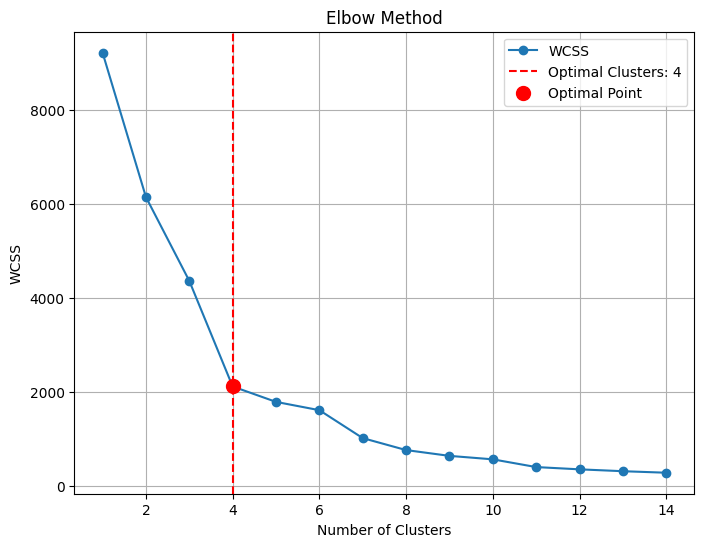

In [ ]:
# Menentukan jumlah cluster optimal menggunakan metode Elbow
wcss = []
for i in range(1, 15):  # Uji dengan 1-10 cluster
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(data_normalized)
    wcss.append(kmeans.inertia_)

# Temukan jumlah cluster optimal menggunakan KneeLocator
knee_locator = KneeLocator(range(1, 14 + 1), wcss, curve="convex", direction="decreasing")
optimal_clusters = knee_locator.knee


# Visualisasi Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(range(1, 14 + 1), wcss, marker='o', label='WCSS')
plt.axvline(x=optimal_clusters, color='r', linestyle='--', label=f"Optimal Clusters: {optimal_clusters}")

# Soroti titik optimal dengan warna berbeda
plt.scatter(optimal_clusters, wcss[optimal_clusters - 1], color='red', s=100, zorder=5, label='Optimal Point')

# Tambahkan judul, label, dan legenda
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.legend()
plt.grid(True)
plt.show()

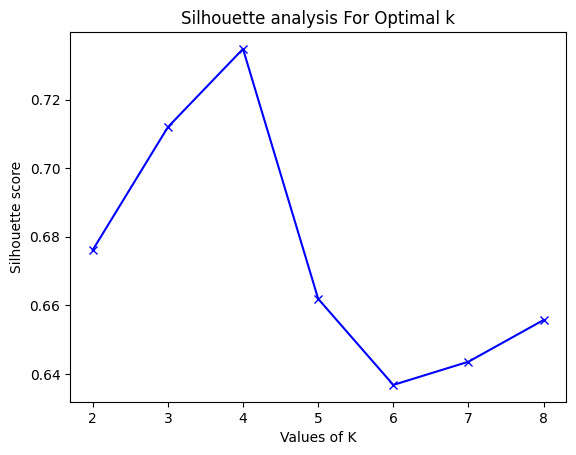

In [ ]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []

for num_clusters in range_n_clusters:
    # Inisialisasi KMeans
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(data_normalized)
    cluster_labels = kmeans.labels_

    # Hitung Silhouette score
    silhouette_avg.append(silhouette_score(data_normalized, cluster_labels))

# Visualisasi hasil Silhouette score
plt.plot(range_n_clusters, silhouette_avg, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()


In [ ]:
# Buat model K-Means dengan jumlah cluster optimal
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
data_cluster['Cluster'] = kmeans.fit_predict(data_normalized)

# Tampilkan hasil clustering
print(f"Optimal Clusters: {optimal_clusters}")
print(data_cluster)

Optimal Clusters: 4
      Potensi  Pelunasan AL  Standarisasi  Cluster
0         1.0           0.0             0        1
1        45.0           0.0             1        0
2        30.0           0.0             0        1
3         3.0           0.0             1        0
4        20.0           0.0             0        1
...       ...           ...           ...      ...
3066    158.0           0.0             0        1
3067    150.0           0.0             0        1
3068     10.0           0.0             0        1
3069      4.0           0.0             0        1
3070    369.0           0.0             0        1

[3071 rows x 4 columns]


In [ ]:
# Menghitung statistik deskriptif untuk setiap kluster
cluster_summary = data_cluster.groupby('Cluster').agg({
    'Potensi': ['mean', 'min', 'max'],
    'Pelunasan AL': ['mean', 'min', 'max'],
    'Standarisasi': ['mean']
}).reset_index()

cluster_summary

Cluster      Potensi                  Pelunasan AL                        \
                  mean     min      max         mean        min        max   
0       0    89.698952    -7.0   1820.0     0.294517   0.000000   5.312842   
1       1    99.039980   -27.0   1848.8     0.258376   0.000000   5.312842   
2       2  3575.530556  1944.0  17748.0     0.230652   0.000000   0.789878   
3       3   480.769231     1.0   2898.0    12.400327  12.400327  12.400327   

  Standarisasi  
          mean  
0     1.000000  
1     0.000000  
2     0.277778  
3     0.076923

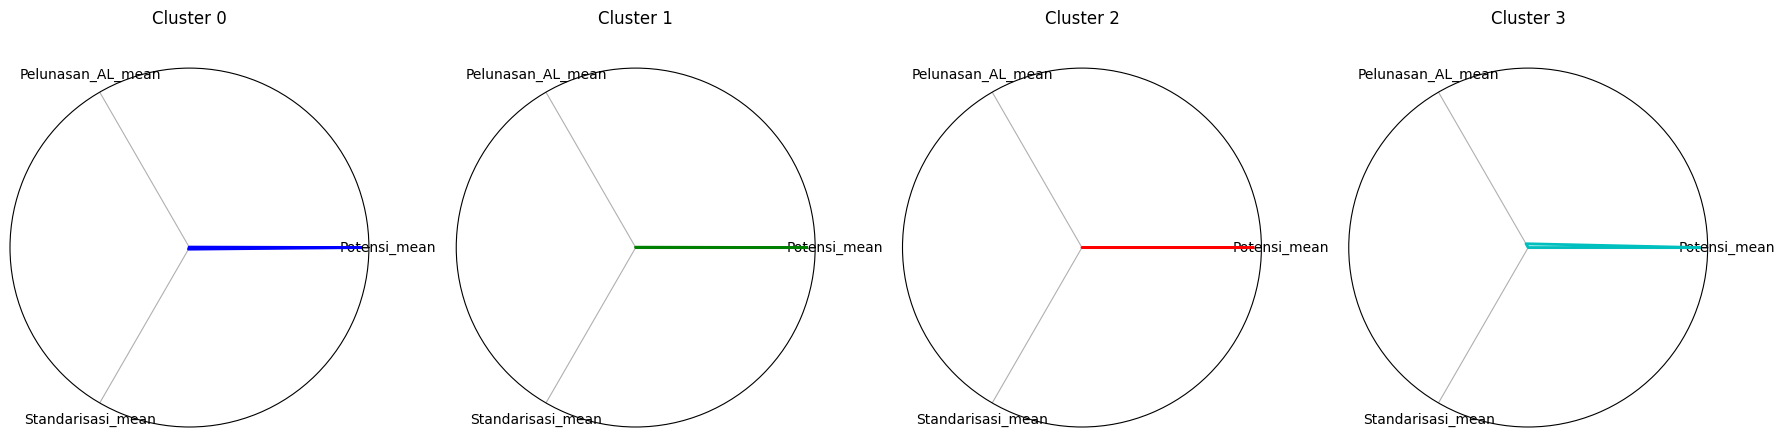

In [ ]:
# Merapikan struktur kolom menjadi satu level
cluster_summary.columns = ['Cluster', 'Potensi_mean', 'Potensi_min', 'Potensi_max',
                           'Pelunasan_AL_mean', 'Pelunasan_AL_min', 'Pelunasan_AL_max',
                           'Standarisasi_mean']

# Variabel yang akan divisualisasikan
categories = ['Potensi_mean', 'Pelunasan_AL_mean', 'Standarisasi_mean']
num_vars = len(categories)

# Fungsi untuk membuat radar chart
def create_radar_chart(ax, data, label, color):
    # Sudut untuk setiap variabel
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Menutup lingkaran

    # Data dan sudut
    values = data.tolist()
    values += values[:1]

    # Membuat radar chart
    ax.fill(angles, values, color=color, alpha=0.25)
    ax.plot(angles, values, color=color, linewidth=2)
    ax.set_yticks([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    ax.set_title(label, size=12, y=1.1)

# Warna untuk setiap cluster
colors = ['b', 'g', 'r', 'c']

# Ukuran plot
fig, axs = plt.subplots(1, 4, figsize=(18, 5), subplot_kw=dict(polar=True))

# Membuat radar chart untuk setiap cluster
for i, ax in enumerate(axs):
    create_radar_chart(
        ax=ax,
        data=cluster_summary.loc[i, categories],
        label=f'Cluster {cluster_summary["Cluster"][i]}',
        color=colors[i]
    )

# Atur layout
plt.tight_layout()
plt.show()

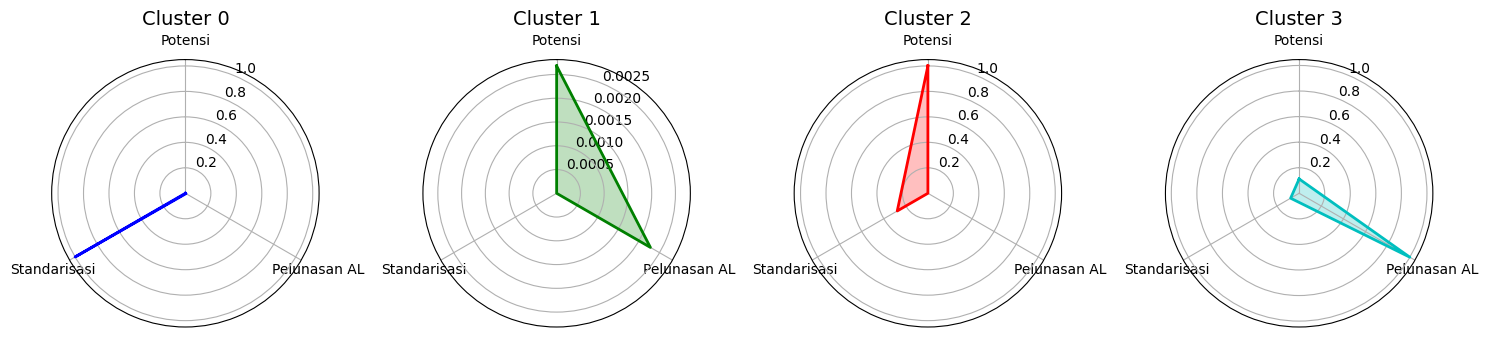

In [ ]:
# Normalisasi data
normalized_means = cluster_means.copy()
for col in normalized_means.columns:
    normalized_means[col] = (normalized_means[col] - normalized_means[col].min()) / (normalized_means[col].max() - normalized_means[col].min())

# Fungsi untuk membuat radar chart dengan warna
def create_radar_chart(ax, data, categories, title, color):
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]
    data = data.tolist() + [data[0]]

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)

    ax.plot(angles, data, linewidth=2, linestyle='solid', color=color)
    ax.fill(angles, data, alpha=0.25, color=color)
    ax.set_title(title, size=14, y=1.1)

# Warna untuk setiap cluster
colors = ['b', 'g', 'r', 'c']

# Plot radar chart
fig, axes = plt.subplots(1, len(normalized_means), figsize=(15, 5), subplot_kw=dict(polar=True))
if len(normalized_means) == 1:
    axes = [axes]

for i, (cluster, row) in enumerate(normalized_means.iterrows()):
    create_radar_chart(axes[i], row, categories, f"Cluster {cluster}", colors[i])

plt.tight_layout()
plt.show()


In [ ]:
cluster_means

,Potensi,Pelunasan AL,Standarisasi
Cluster,,,
0,0.005054,0.023751,1.000000
1,0.005580,0.020836,0.000000
2,0.201461,0.018600,0.277778
3,0.027089,1.000000,0.076923


In [ ]:
data_cluster.head()

,Potensi,Pelunasan AL,Standarisasi,Cluster
0,0.000056,0.0,0.0,1
1,0.002535,0.0,1.0,0
2,0.001690,0.0,0.0,1
3,0.000169,0.0,1.0,0
4,0.001127,0.0,0.0,1


In [ ]:
data_final['Cluster'] = data_cluster['Cluster'].values
data_final

,Kode Dokter,Kode RS,Kode Spesialis,Zat Aktif,Nama Produk,Kode Produk,Potensi,Pelunasan AL,Keterangan Produk (Alasan Penggunaan Produk),Standarisasi,Cluster
0,A1000684,A1005681,003,CEFADROXIL,CEFADROXIL 500 MG CAPSULE OGB,018901,1.0,0.0,BELUM TERCATAT,Tidak,1
1,A1000914,A1005681,008,LEVOFLOXACIN,NISLEV 500 TABLET FC,006383,45.0,0.0,ANTIBIOTIK SALURAN PERNAPASAN,Ya,0
2,A1000925,A1005681,004,CLOPIDOGREL,ARTEPID 75 MG FC TABLET,008506,30.0,0.0,PRODUK INTERNIST (ANTIPLATELET),Tidak,1
3,A1000925,A1005681,004,MOXIFLOXACIN HCl,ZIGAT 400 MG FC TABLET,012818,3.0,0.0,"ANTIBIOTIK SAL PERNAPASAN, SAL PENCERNAAN, DAN...",Ya,0
4,A1000925,A1005681,004,TADALAFIL,MODAFIL 20 MG FC TABLET,012895,20.0,0.0,DISFUNGSI EREKSI,Tidak,1
...,...,...,...,...,...,...,...,...,...,...,...
3066,M1000136,HD000038,003,CLOBETASOL PROPIONATE,HERCUM 0.05 % CREAM 10 G,009100,158.0,0.0,BELUM TERCATAT,Tidak,1
3067,M1000136,HD000038,003,CLOPIDOGREL,ARTEPID 75 MG FC TABLET,008506,150.0,0.0,BELUM TERCATAT,Tidak,1
3068,M1000136,HD000038,003,LEVOFLOXACIN,NISLEV 500 TABLET FC,006383,10.0,0.0,BELUM TERCATAT,Tidak,1
3069,M1000136,HD000038,003,METFORMIN HCL,GLICOLOCK 750 MG XR CAPLET,029703,4.0,0.0,BELUM TERCATAT,Tidak,1


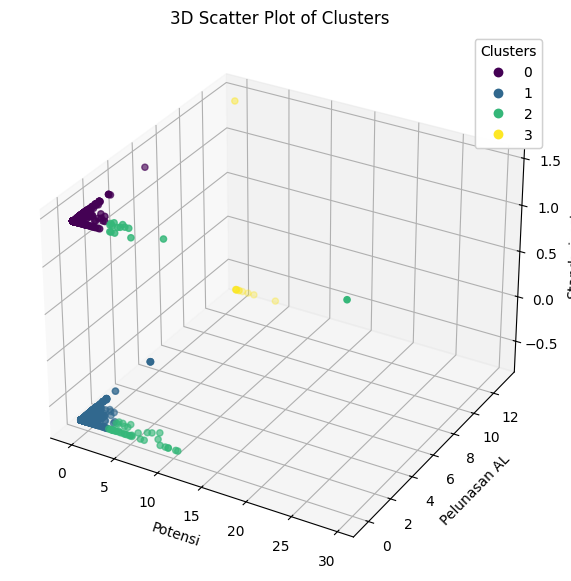

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Misalkan data_normalized adalah data yang sudah dinormalisasi dan kmeans.labels_ adalah hasil cluster
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot 3D
scatter = ax.scatter(data_normalized[:, 0], data_normalized[:, 1], data_normalized[:, 2], c=kmeans.labels_, cmap='viridis')

# Menambahkan label dan judul
ax.set_xlabel('Potensi')
ax.set_ylabel('Pelunasan AL')
ax.set_zlabel('Standarisasi')
plt.title('3D Scatter Plot of Clusters')

# Menampilkan legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()


In [ ]:
data_final['Cluster'].value_counts().reset_index()

,Cluster,count
0,1,2021
1,0,983
2,2,54
3,3,13


In [ ]:
# Fungsi untuk mendapatkan modus dari kolom kategorikal
def get_mode(series):
    return series.mode()[0]  # Ambil nilai modus pertama

# Lakukan groupby dan agregasi
aggregated_data = data_final.groupby('Cluster').agg({
    'Potensi': 'mean',               # Rata-rata Potensi
    'Pelunasan AL': 'mean',# Rata-rata Pelunasan AL
    'Standarisasi': get_mode # Modus untuk kolom Standarisasi
}).reset_index()

# Menampilkan hasil agregasi
aggregated_data

,Cluster,Potensi,Pelunasan AL,Standarisasi
0,0,89.698952,0.294517,Ya
1,1,99.039980,0.258376,Tidak
2,2,3575.530556,0.230652,Tidak
3,3,480.769231,12.400327,Tidak


Definis Cluster:
* Cluster 0 : Memiliki potensi dan pelunasan AL yang rendah tetapi sebagain besar sudah terstandarisasi.
* Cluster 1 : Memiliki potensi dan pelunasan AL yang rendah tetapi sebagian besar belum terstandarisasi
* Cluster 2 : Memiliki potensi yang tinggi, pelunasan AL yang rendah, dan sebagian belum terstandarisasi
* Cluster 3 : Memiliki potensi sedang, pelunasan AL tinggi dan belum terstandarisasi

Kelompok Prioritas
* Prioritas 1 : Cluster 2 (Potensi tinggi dengan peluang peningkatan pelunasan dan standarisasi).
* Prioritas 2 : Cluster 3 (Kontribusi pelunasan sangat tinggi dan potensi sedang yang perlu dipertahankan).
* Prioritas 3: Cluster 0 (Potensi rendah tetapi sudah distandarisasi, effort minimal).
* Prioritas 4 : Cluster 1 (Potensi dan kontribusi rendah, alokasi sumber daya minimal).

In [ ]:
data_final_terstandarisasi = data_final[data_final['Standarisasi'] == 'Ya']
data_final_cluster_1 = data_final_terstandarisasi[['Potensi','Pelunasan AL','Standarisasi']]
data_final_cluster_1['Standarisasi'] = data_final_cluster_1['Standarisasi'].map({'Ya': 1})
data_normalized_1 = StandardScaler().fit_transform(data_final_cluster_1)
data_normalized_1

array([[-0.22708662, -0.50168967,  0.        ],
       [ 1.07062189, -0.50168967,  0.        ],
       [-0.23759911, -0.50168967,  0.        ],
       ...,
       [-0.24577549, -0.50168967,  0.        ],
       [-0.24927966, -0.50168967,  0.        ],
       [ 1.53200341, -0.50168967,  0.        ]])

In [ ]:
#Melihat rerata potensi dan pelunasan AL berdasarkan standarisasi
data_group_standari = data_final.groupby('Standarisasi').agg(
    rerata_potensi=('Potensi', 'mean'),
    rerata_pelunasan_AL=('Pelunasan AL', 'mean')
).reset_index()

data_group_standari

,Standarisasi,rerata_potensi,rerata_pelunasan_AL
0,Tidak,164.899831,0.327107
1,Ya,146.136206,0.307890


In [ ]:
'''
Membuat kategori prioritas

- Digunakan untuk menentukan prioritas kunjungan
- Pembagian prioritas adalah yaitu:
  * Prioritas 1 : Nilai potensi dan pelunasan AL lebih dari reratanya dan sudah terstandarisasi
  * Prioritas 2 : Nilai potensi dan pelunasan AL kurang dari reratanya dan sudah terstandarisasi
  * Prioritas 3 : Nilai potensi dan pelunasan AL lebih dari reratanya dan belum terstandarisasi
  * Prioritas 4 : Nilai potensi dan pelunasan AL kurang dari reratanya dan belum terstandarisasi
'''

rerata_potensi = data_final['Potensi'].mean()
rerata_pelunasan_al = data_final['Pelunasan AL'].mean()

def buat_prioritas(row):
  if row['Standarisasi'] == 'Ya':  # Sudah terstandarisasi
        if row['Potensi'] > rerata_potensi and row['Pelunasan AL'] > rerata_pelunasan_al:
            return 'Prioritas 1'
        else:
            return 'Prioritas 2'
  else:  # Belum terstandarisasi
        if row['Potensi'] > rerata_potensi and row['Pelunasan AL'] > rerata_pelunasan_al:
            return 'Prioritas 3'
        else:
            return 'Prioritas 4'

# Terapkan fungsi ke DataFrame untuk mengassign prioritas
data_final['Prioritas'] = data_final.apply(buat_prioritas, axis=1)
data_final.head()

,Kode Dokter,Kode RS,Kode Spesialis,Zat Aktif,Nama Produk,Kode Produk,Potensi,Pelunasan AL,Keterangan Produk (Alasan Penggunaan Produk),Standarisasi,Cluster,Prioritas
0,A1000684,A1005681,003,CEFADROXIL,CEFADROXIL 500 MG CAPSULE OGB,018901,1.0,0.0,BELUM TERCATAT,Tidak,1,Prioritas 4
1,A1000914,A1005681,008,LEVOFLOXACIN,NISLEV 500 TABLET FC,006383,45.0,0.0,ANTIBIOTIK SALURAN PERNAPASAN,Ya,0,Prioritas 2
2,A1000925,A1005681,004,CLOPIDOGREL,ARTEPID 75 MG FC TABLET,008506,30.0,0.0,PRODUK INTERNIST (ANTIPLATELET),Tidak,1,Prioritas 4
3,A1000925,A1005681,004,MOXIFLOXACIN HCl,ZIGAT 400 MG FC TABLET,012818,3.0,0.0,"ANTIBIOTIK SAL PERNAPASAN, SAL PENCERNAAN, DAN...",Ya,0,Prioritas 2
4,A1000925,A1005681,004,TADALAFIL,MODAFIL 20 MG FC TABLET,012895,20.0,0.0,DISFUNGSI EREKSI,Tidak,1,Prioritas 4


In [ ]:
data_final['Prioritas'].value_counts().reset_index()

,Prioritas,count
0,Prioritas 4,1957
1,Prioritas 2,943
2,Prioritas 3,115
3,Prioritas 1,56


In [ ]:
data_final_1 = data_final.merge(data_dokter[['Kd Dokter\n(DB Pharos)','Doctor Name \n(DB Pharos)','Kd Spesialis \n(DB Pharos)','Nama Spesialis\n(DB Pharos)']],
                              left_on = ['Kode Dokter','Kode Spesialis'],
                              right_on = ['Kd Dokter\n(DB Pharos)','Kd Spesialis \n(DB Pharos)'],
                              how = 'left')
data_final_1 = data_final_1.drop(columns=['Kd Dokter\n(DB Pharos)','Kd Spesialis \n(DB Pharos)'])

data_final_1 = data_final_1.merge(data_struktur_PI[['KodePI','NamaOutlet']],
                              left_on = 'Kode RS',
                              right_on = ['KodePI'],
                              how = 'left')
data_final_1 = data_final_1.drop(columns="KodePI")

data_final_1 = data_final_1.rename(columns={
    'Doctor Name \n(DB Pharos)':'Nama Dokter',
    'Nama Spesialis\n(DB Pharos)' : 'Spesialis',
    'NamaOutlet' : 'Nama RS'
})

data_final_1 = data_final_1.reindex(columns=['Kode Dokter','Nama Dokter','Kode RS','Nama RS','Kode Spesialis','Spesialis',
                                             'Zat Aktif','Kode Produk','Nama Produk','Keterangan Produk (Alasan Penggunaan Produk)',
                                             'Potensi', 'Pelunasan AL','Standarisasi','Cluster', 'Prioritas'])

data_final_1 = data_final_1.drop_duplicates()
data_final_1.head()


,Kode Dokter,Nama Dokter,Kode RS,Nama RS,Kode Spesialis,Spesialis,Zat Aktif,Kode Produk,Nama Produk,Keterangan Produk (Alasan Penggunaan Produk),Potensi,Pelunasan AL,Standarisasi,Cluster,Prioritas
0,A1000684,"ERINA OUTRY SIREGAR SpB, DR",A1005681,"COLUMBIA ASIA MEDAN, RS",003,BEDAH (SURGEON),CEFADROXIL,018901,CEFADROXIL 500 MG CAPSULE OGB,BELUM TERCATAT,1.0,0.0,Tidak,1,Prioritas 4
1,A1000914,"TAMSIL SYAFIUDIN SpP, DR",A1005681,"COLUMBIA ASIA MEDAN, RS",008,PARU (PULMONOLOGI),LEVOFLOXACIN,006383,NISLEV 500 TABLET FC,ANTIBIOTIK SALURAN PERNAPASAN,45.0,0.0,Ya,0,Prioritas 2
2,A1000925,"SUTOMO KASIMAN SpPD, DR",A1005681,"COLUMBIA ASIA MEDAN, RS",004,PENYAKIT DALAM (INTERNIST),CLOPIDOGREL,008506,ARTEPID 75 MG FC TABLET,PRODUK INTERNIST (ANTIPLATELET),30.0,0.0,Tidak,1,Prioritas 4
3,A1000925,"SUTOMO KASIMAN SpPD, DR",A1005681,"COLUMBIA ASIA MEDAN, RS",004,PENYAKIT DALAM (INTERNIST),MOXIFLOXACIN HCl,012818,ZIGAT 400 MG FC TABLET,"ANTIBIOTIK SAL PERNAPASAN, SAL PENCERNAAN, DAN...",3.0,0.0,Ya,0,Prioritas 2
4,A1000925,"SUTOMO KASIMAN SpPD, DR",A1005681,"COLUMBIA ASIA MEDAN, RS",004,PENYAKIT DALAM (INTERNIST),TADALAFIL,012895,MODAFIL 20 MG FC TABLET,DISFUNGSI EREKSI,20.0,0.0,Tidak,1,Prioritas 4


In [ ]:
data_final_1.to_csv('Data Final Rekomendasi.csv', index=False)
data_final_1.to_excel("Data Final Rekomendasi.xlsx", index=False)